This is the notebook for the Dock Door Case Study by Ayoub Youssoufi and Marlize de Villiers in collaboration with Mr Christophe Loussert from Mojix.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

from scipy.signal import argrelmax
from scipy.signal import find_peaks
import sklearn

In [2]:
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu
add_notebook_menu()

## RFID tags per run

In [3]:
pathfile_runs='runs'
Files=os.listdir(pathfile_runs)
tags=pd.DataFrame()
gpio=pd.DataFrame()
runs=pd.DataFrame()
# 
for file in Files:
    filename=os.path.join(pathfile_runs, file)
    with open(filename, 'r') as f:
        run = f.readline()
        reader_settings = f.readline()
        cols = f.readline()
    run = run.lstrip('// ').rstrip('\n')
    run = pd.to_datetime(run)
# 
    reader_settings = reader_settings.lstrip('// ').rstrip('\n').split(', ')
    reader_settings = {x.split('=')[0]:x.split('=')[1] for x in reader_settings}
#     
    cols = cols.lstrip('// ').rstrip('\n').split(', ')
#     
    run_settings={x.split('=')[0]:x.split('=')[1] for x in file.rstrip('.csv').split('__')[:-1]}
    run_settings['run']=run
#     
    settings = {**run_settings, **reader_settings}
    runs_temp=pd.DataFrame([settings])
#     
    tags_temp=pd.read_csv(filename, sep=';', names=cols)[3:]
#     
    gpio_raw = tags_temp [ tags_temp['EPC'].isna() ].reset_index(drop=True)
#     gpio_raw
    gpio_temp=pd.DataFrame()
    gpio_temp['Timestamp'] = gpio_raw['Timestamp'].apply(lambda x:x.split(' ')[-1])
    gpio_temp['status'] = gpio_raw['Timestamp'].apply(lambda x:x.split(' ')[-3])
    gpio_temp['GPI Event Port'] = gpio_raw['Timestamp'].apply(lambda x:x.split(' ')[-5])
    gpio_temp['Timestamp'] = pd.to_datetime(gpio_temp['Timestamp'])
    gpio_temp = gpio_temp[['Timestamp', 'status', 'GPI Event Port']]
    gpio_temp = gpio_temp.drop_duplicates('Timestamp')
    Tstartrunmin_gpio = gpio_temp [ gpio_temp['status']=='high'] ['Timestamp'].min()
    gpio_temp = gpio_temp [ gpio_temp['Timestamp']>Tstartrunmin_gpio ].reset_index(drop=True)
    Tstartrun_gpio = gpio_temp [ gpio_temp['status']=='low'] ['Timestamp'].min()
    Tstoprun_gpio = gpio_temp [ gpio_temp['status']=='high'] ['Timestamp'].max()
    gpio_run=pd.DataFrame({'run':[run], 'gpio_start':[Tstartrun_gpio], 'gpio_stop':[Tstoprun_gpio]})
# 
    tags_temp = tags_temp [ ~tags_temp['EPC'].isna() ].reset_index(drop=True)
#     
    for key, value in settings.items():
        tags_temp[key]=value
    tags = tags.append(tags_temp)
    runs = runs.append(runs_temp)
    gpio = gpio.append(gpio_run)
tags['Timestamp'] = pd.to_datetime(tags['Timestamp'])
tags['Timestamp'] = tags['Timestamp'].apply(lambda x:x.to_datetime64())
tags['Antenna'] = tags['Antenna'].astype(int)
tags['RSSI'] = tags['RSSI'].apply(lambda x:x.replace(',','.')).astype(float)
tags['RSSIlin'] = 10**6 * 10**(tags['RSSI']/10) 
tags['Frequency'] = tags['Frequency'].apply(lambda x:x.replace(',','.')).astype(float)
tags = tags.sort_values('Timestamp', ascending=True).reset_index(drop=True)
runs = runs.reset_index(drop=True)
# 
# if keep_out
# 
if 'keep_out' in tags.columns:
    tags['keep_out'] = tags['keep_out'].astype(float)
    runs['keep_out'] = runs['keep_out'].astype(float)
    
gpio = gpio.reset_index(drop=True)
# 
tags.head()

,Timestamp,EPC,TID,Antenna,RSSI,Frequency,Hostname,PhaseAngle,DopplerFrequency,hw_conf,...,stat_height,run,ReaderName,AntennaIDs,InventoryMode,ModeIndex,Population,PowerInDbm,Session,RSSIlin
0,2022-02-18 16:05:33.459318,AD3830770CCDD0AD3830041B,NaN,1,-69.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,1,2022-02-18 17:05:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,0.125893
1,2022-02-18 16:05:33.460875,AD3830770CCDD0AD38300284,NaN,1,-57.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,1,2022-02-18 17:05:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,1.778279
2,2022-02-18 16:05:33.462391,AD3830770CCDD0AD383002D3,NaN,1,-59.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,1,2022-02-18 17:05:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,1.122018
3,2022-02-18 16:05:33.464342,AD3830770CCDD0AD38300435,NaN,1,-68.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,1,2022-02-18 17:05:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,0.141254
4,2022-02-18 16:05:33.465858,AD3830770CCDD0AD383001DE,NaN,1,-71.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,1,2022-02-18 17:05:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,0.070795


In [4]:
tags = tags.drop_duplicates(['EPC', 'Timestamp', 'Antenna', 'RSSI'])

In [5]:
tags.groupby('run').apply(lambda x:(x['Timestamp'].max()-x['Timestamp'].min())).sum()

Timedelta('0 days 00:22:42.242582')

In [6]:
runs.head()

,hw_conf,moving_TOI,moving_motion,moving_xstart,moving_xstop,moving_height,stat_TOI,stat_zone,stat_x,stat_height,run,ReaderName,AntennaIDs,InventoryMode,ModeIndex,Population,PowerInDbm,Session
0,2in2out,A,IN_OUT,1,-1,1,B,IN,1,1,2022-02-18 17:05:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1
1,2in2out,A,IN_OUT,1,-1,1,B,IN,3,1,2022-02-18 17:06:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1
2,2in2out,A,IN_OUT,1,-1,1,B,IN,5,1,2022-02-18 17:07:23,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1
3,2in2out,A,IN_OUT,1,-1,1,B,OUT,-1,1,2022-02-18 17:08:20,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1
4,2in2out,A,IN_OUT,1,-1,1,B,OUT,-3,1,2022-02-18 17:09:10,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1


In [7]:
len(runs)

72

## Keep out

In [8]:
runs['moving_xstart'] = runs['moving_xstart'].astype(float)
runs['moving_xstop'] = runs['moving_xstop'].astype(float)
runs['stat_x'] = runs['stat_x'].astype(float)

keep_out_list = abs(pd.concat([runs['moving_xstart'], runs['moving_xstop'], runs['stat_x']])).unique()

for keep_out in keep_out_list:
    crit = (abs(runs['moving_xstart'])>=keep_out) \
                    & (abs(runs['moving_xstop'])>=keep_out) \
                    & (abs(runs['stat_x'])>=keep_out)
    index_keep_out = crit[crit].index
    runs.loc[index_keep_out, 'keep_out'] = keep_out
runs.head()

,hw_conf,moving_TOI,moving_motion,moving_xstart,moving_xstop,moving_height,stat_TOI,stat_zone,stat_x,stat_height,run,ReaderName,AntennaIDs,InventoryMode,ModeIndex,Population,PowerInDbm,Session,keep_out
0,2in2out,A,IN_OUT,1.0,-1.0,1,B,IN,1.0,1,2022-02-18 17:05:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,1.0
1,2in2out,A,IN_OUT,1.0,-1.0,1,B,IN,3.0,1,2022-02-18 17:06:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,1.0
2,2in2out,A,IN_OUT,1.0,-1.0,1,B,IN,5.0,1,2022-02-18 17:07:23,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,1.0
3,2in2out,A,IN_OUT,1.0,-1.0,1,B,OUT,-1.0,1,2022-02-18 17:08:20,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,1.0
4,2in2out,A,IN_OUT,1.0,-1.0,1,B,OUT,-3.0,1,2022-02-18 17:09:10,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,1.0


In [9]:
runs.groupby('keep_out')['moving_xstart'].unique()

keep_out
1.0    [1.0, 3.0, 5.0, -1.0, -3.0, -5.0]
3.0               [3.0, 5.0, -3.0, -5.0]
5.0                          [5.0, -5.0]
Name: moving_xstart, dtype: object

In [10]:
tags = pd.merge(tags, runs[['run', 'keep_out']], on='run')
tags.head()

,Timestamp,EPC,TID,Antenna,RSSI,Frequency,Hostname,PhaseAngle,DopplerFrequency,hw_conf,...,run,ReaderName,AntennaIDs,InventoryMode,ModeIndex,Population,PowerInDbm,Session,RSSIlin,keep_out
0,2022-02-18 16:05:33.459318,AD3830770CCDD0AD3830041B,NaN,1,-69.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,2022-02-18 17:05:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,0.125893,1.0
1,2022-02-18 16:05:33.460875,AD3830770CCDD0AD38300284,NaN,1,-57.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,2022-02-18 17:05:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,1.778279,1.0
2,2022-02-18 16:05:33.462391,AD3830770CCDD0AD383002D3,NaN,1,-59.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,2022-02-18 17:05:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,1.122018,1.0
3,2022-02-18 16:05:33.464342,AD3830770CCDD0AD38300435,NaN,1,-68.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,2022-02-18 17:05:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,0.141254,1.0
4,2022-02-18 16:05:33.465858,AD3830770CCDD0AD383001DE,NaN,1,-71.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,2022-02-18 17:05:31,169.254.1.1,"1,2,3,4",SingleTarget,1000,32,30,1,0.070795,1.0


## Tag-of-interest ref list

In [11]:
pathfile_reflist = 'reflist'
Files = os.listdir(pathfile_reflist)
reflist=pd.DataFrame()
for file in Files:
    file_dict = {x.split('=')[0]:x.split('=')[1] for x in file.rstrip('.csv').split('__')}
    filename=os.path.join(pathfile_reflist, file)
    temp=pd.read_csv(filename, sep=';', names=['EPC'])
    for key, value in file_dict.items():
        temp[key] = value
    reflist = reflist.append(temp)
reflist = reflist.reset_index(drop=True)
reflist.head()

,EPC,TOI,tag_size
0,AD3830770CCDD0AD38300403,A,15cm2
1,AD3830770CCDD0AD38300424,A,15cm2
2,AD3830770CCDD0AD38300202,A,15cm2
3,AD3830770CCDD0AD383004AF,A,15cm2
4,AD3830770CCDD0AD383003F7,A,15cm2


In [12]:
reflist.groupby('TOI').size()

TOI
A    100
B     10
dtype: int64

## Merge tags with reflist

In [13]:
tags = pd.merge(tags, reflist,on='EPC', how='inner')
tags.head()

,Timestamp,EPC,TID,Antenna,RSSI,Frequency,Hostname,PhaseAngle,DopplerFrequency,hw_conf,...,AntennaIDs,InventoryMode,ModeIndex,Population,PowerInDbm,Session,RSSIlin,keep_out,TOI,tag_size
0,2022-02-18 16:05:33.459318,AD3830770CCDD0AD3830041B,NaN,1,-69.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,"1,2,3,4",SingleTarget,1000,32,30,1,0.125893,1.0,A,15cm2
1,2022-02-18 16:05:34.942971,AD3830770CCDD0AD3830041B,NaN,1,-72.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,"1,2,3,4",SingleTarget,1000,32,30,1,0.063096,1.0,A,15cm2
2,2022-02-18 16:05:36.581668,AD3830770CCDD0AD3830041B,NaN,2,-70.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,"1,2,3,4",SingleTarget,1000,32,30,1,0.089125,1.0,A,15cm2
3,2022-02-18 16:05:38.288647,AD3830770CCDD0AD3830041B,NaN,2,-74.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,"1,2,3,4",SingleTarget,1000,32,30,1,0.039811,1.0,A,15cm2
4,2022-02-18 16:05:39.889996,AD3830770CCDD0AD3830041B,NaN,2,-73.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,"1,2,3,4",SingleTarget,1000,32,30,1,0.050119,1.0,A,15cm2


In [14]:
tags[['EPC', 'TOI', 'run', 'Timestamp', 'Antenna', 'RSSI']].head()

,EPC,TOI,run,Timestamp,Antenna,RSSI
0,AD3830770CCDD0AD3830041B,A,2022-02-18 17:05:31,2022-02-18 16:05:33.459318,1,-69.0
1,AD3830770CCDD0AD3830041B,A,2022-02-18 17:05:31,2022-02-18 16:05:34.942971,1,-72.0
2,AD3830770CCDD0AD3830041B,A,2022-02-18 17:05:31,2022-02-18 16:05:36.581668,2,-70.5
3,AD3830770CCDD0AD3830041B,A,2022-02-18 17:05:31,2022-02-18 16:05:38.288647,2,-74.0
4,AD3830770CCDD0AD3830041B,A,2022-02-18 17:05:31,2022-02-18 16:05:39.889996,2,-73.0


In [15]:
tags.shape

(53264, 31)

## Hardware configuration

In [16]:
hw_config=pd.DataFrame()
pathfile_hw_config = 'hw_config'
Files = os.listdir(pathfile_hw_config)

for file in Files:
    settings = {x.split('=')[0]:x.split('=')[1] for x in file.rstrip('.csv').split('__')}
    filename=os.path.join(pathfile_hw_config, file)
    temp = pd.read_csv(filename, sep=';')
    for key, value in settings.items():
        temp[key]=value
    hw_config = hw_config.append(temp)
hw_config['Antenna'] = hw_config['Antenna'].astype(int)
hw_config

,ReaderName,Antenna,Antenna_coverage,Antenna_zone,Antenna_position,hw_conf
0,169.254.1.1,1,ain,border_flat,floor,1in
0,10.113.116.152,1,aout,border_45deg_in,floor,1in1out
1,10.113.116.152,2,ain,border_45deg_out,floor,1in1out
0,169.254.1.1,1,ain,border_45deg_in,floor,2in2out
1,169.254.1.1,2,ain,border_45deg_out,floor,2in2out
2,169.254.1.1,3,aout,border_45deg_in,floor,2in2out
3,169.254.1.1,4,aout,border_45deg_out,floor,2in2out


In [17]:
tags = pd.merge(tags, hw_config, on=['hw_conf', 'ReaderName', 'Antenna'])
tags.head()

,Timestamp,EPC,TID,Antenna,RSSI,Frequency,Hostname,PhaseAngle,DopplerFrequency,hw_conf,...,Population,PowerInDbm,Session,RSSIlin,keep_out,TOI,tag_size,Antenna_coverage,Antenna_zone,Antenna_position
0,2022-02-18 16:05:33.459318,AD3830770CCDD0AD3830041B,NaN,1,-69.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,32,30,1,0.125893,1.0,A,15cm2,ain,border_45deg_in,floor
1,2022-02-18 16:05:34.942971,AD3830770CCDD0AD3830041B,NaN,1,-72.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,32,30,1,0.063096,1.0,A,15cm2,ain,border_45deg_in,floor
2,2022-02-18 16:05:39.996616,AD3830770CCDD0AD3830041B,NaN,1,-71.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,32,30,1,0.070795,1.0,A,15cm2,ain,border_45deg_in,floor
3,2022-02-18 16:06:33.821943,AD3830770CCDD0AD3830041B,NaN,1,-66.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,32,30,1,0.223872,1.0,A,15cm2,ain,border_45deg_in,floor
4,2022-02-18 16:06:34.691724,AD3830770CCDD0AD3830041B,NaN,1,-66.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,32,30,1,0.251189,1.0,A,15cm2,ain,border_45deg_in,floor


In [18]:
tags[['EPC', 'TOI', 'run', 'Timestamp', 'Antenna', 'Antenna_coverage', 'RSSI']].head()

,EPC,TOI,run,Timestamp,Antenna,Antenna_coverage,RSSI
0,AD3830770CCDD0AD3830041B,A,2022-02-18 17:05:31,2022-02-18 16:05:33.459318,1,ain,-69.0
1,AD3830770CCDD0AD3830041B,A,2022-02-18 17:05:31,2022-02-18 16:05:34.942971,1,ain,-72.0
2,AD3830770CCDD0AD3830041B,A,2022-02-18 17:05:31,2022-02-18 16:05:39.996616,1,ain,-71.5
3,AD3830770CCDD0AD3830041B,A,2022-02-18 17:06:31,2022-02-18 16:06:33.821943,1,ain,-66.5
4,AD3830770CCDD0AD3830041B,A,2022-02-18 17:06:31,2022-02-18 16:06:34.691724,1,ain,-66.0


In [19]:
tags['Antenna_coverage'].unique()

array(['ain', 'aout'], dtype=object)

## Actual motion/location

In [20]:
runs['stat_zone'].unique()

array(['IN', 'OUT'], dtype=object)

In [21]:
for i, row in runs.iterrows():
    run=row['run']
    moving_TOI=row['moving_TOI']
    moving_motion=row['moving_motion']
    stat_TOI=row['stat_TOI']
    stat_zone=row['stat_zone']
    actual_moving = 'moving_'+ moving_motion
    actual_stat = 'stat_' + stat_zone
#     
    tags_run = tags [ tags['run'] == run ]
    index_tags_run = tags_run.index
    crit = (tags_run['TOI'] == moving_TOI)
    tags.loc[index_tags_run,'actual'] = np.where(crit, actual_moving, actual_stat)
tags.head()

,Timestamp,EPC,TID,Antenna,RSSI,Frequency,Hostname,PhaseAngle,DopplerFrequency,hw_conf,...,PowerInDbm,Session,RSSIlin,keep_out,TOI,tag_size,Antenna_coverage,Antenna_zone,Antenna_position,actual
0,2022-02-18 16:05:33.459318,AD3830770CCDD0AD3830041B,NaN,1,-69.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,30,1,0.125893,1.0,A,15cm2,ain,border_45deg_in,floor,moving_IN_OUT
1,2022-02-18 16:05:34.942971,AD3830770CCDD0AD3830041B,NaN,1,-72.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,30,1,0.063096,1.0,A,15cm2,ain,border_45deg_in,floor,moving_IN_OUT
2,2022-02-18 16:05:39.996616,AD3830770CCDD0AD3830041B,NaN,1,-71.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,30,1,0.070795,1.0,A,15cm2,ain,border_45deg_in,floor,moving_IN_OUT
3,2022-02-18 16:06:33.821943,AD3830770CCDD0AD3830041B,NaN,1,-66.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,30,1,0.223872,1.0,A,15cm2,ain,border_45deg_in,floor,moving_IN_OUT
4,2022-02-18 16:06:34.691724,AD3830770CCDD0AD3830041B,NaN,1,-66.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,30,1,0.251189,1.0,A,15cm2,ain,border_45deg_in,floor,moving_IN_OUT


In [22]:
tags['actual'].unique()

array(['moving_IN_OUT', 'moving_OUT_IN', 'stat_IN', 'stat_OUT'],
      dtype=object)

In [23]:
tags['moving_stat'] = tags['actual'].apply(lambda x:x.split('_')[0])
tags.head()

,Timestamp,EPC,TID,Antenna,RSSI,Frequency,Hostname,PhaseAngle,DopplerFrequency,hw_conf,...,Session,RSSIlin,keep_out,TOI,tag_size,Antenna_coverage,Antenna_zone,Antenna_position,actual,moving_stat
0,2022-02-18 16:05:33.459318,AD3830770CCDD0AD3830041B,NaN,1,-69.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,1,0.125893,1.0,A,15cm2,ain,border_45deg_in,floor,moving_IN_OUT,moving
1,2022-02-18 16:05:34.942971,AD3830770CCDD0AD3830041B,NaN,1,-72.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,1,0.063096,1.0,A,15cm2,ain,border_45deg_in,floor,moving_IN_OUT,moving
2,2022-02-18 16:05:39.996616,AD3830770CCDD0AD3830041B,NaN,1,-71.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,1,0.070795,1.0,A,15cm2,ain,border_45deg_in,floor,moving_IN_OUT,moving
3,2022-02-18 16:06:33.821943,AD3830770CCDD0AD3830041B,NaN,1,-66.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,1,0.223872,1.0,A,15cm2,ain,border_45deg_in,floor,moving_IN_OUT,moving
4,2022-02-18 16:06:34.691724,AD3830770CCDD0AD3830041B,NaN,1,-66.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,1,0.251189,1.0,A,15cm2,ain,border_45deg_in,floor,moving_IN_OUT,moving


In [24]:
tags.columns

Index(['Timestamp', 'EPC', 'TID', 'Antenna', 'RSSI', 'Frequency', 'Hostname',
       'PhaseAngle', 'DopplerFrequency', 'hw_conf', 'moving_TOI',
       'moving_motion', 'moving_xstart', 'moving_xstop', 'moving_height',
       'stat_TOI', 'stat_zone', 'stat_x', 'stat_height', 'run', 'ReaderName',
       'AntennaIDs', 'InventoryMode', 'ModeIndex', 'Population', 'PowerInDbm',
       'Session', 'RSSIlin', 'keep_out', 'TOI', 'tag_size', 'Antenna_coverage',
       'Antenna_zone', 'Antenna_position', 'actual', 'moving_stat'],
      dtype='object')

In [25]:
tags.groupby('actual').size()

actual
moving_IN_OUT    15516
moving_OUT_IN    14957
stat_IN          11198
stat_OUT         11593
dtype: int64

## Tags crossing dock door

In [26]:
tags['crossing'] = tags['actual'].apply(lambda x:('IN_OUT' in x) or ('OUT_IN' in x))

In [27]:
tags.groupby('crossing').size()

crossing
False    22791
True     30473
dtype: int64

## 1 second slots of observations from run start

In [28]:
Slots=pd.DataFrame()
for run in runs['run']:
    tags_run = tags [ tags['run']==run ]
    Tmin = tags_run['Timestamp'].min().to_datetime64()
    Tmax = tags_run['Timestamp'].max().to_datetime64()
    gpio_run = gpio [ gpio['run']==run ]
    gpio_start = gpio_run['gpio_start'].values[0]
    gpio_stop = gpio_run['gpio_stop'].values[0]
    gpio_center = gpio_start + (gpio_stop-gpio_start)/2
#     
    timedelta_pos = pd.Timedelta(1, unit='sec')
    Slots_up = pd.DataFrame({'slotStart':pd.date_range(start=gpio_center, end=Tmax, freq=timedelta_pos)})
    Slots_up['slot_id']=range(0,len(Slots_up))
#     
    timedelta_neg=pd.Timedelta(-1, unit='sec')
    Slots_down = pd.DataFrame({'slotStart':pd.date_range(start=gpio_center, end=Tmin, freq=timedelta_neg, closed='right')})
    Slots_down['slot_id'] = range(-1,-len(Slots_down)-1, -1)
# 
    Slots_run = pd.concat([Slots_up, Slots_down], axis=0).sort_values('slotStart', ascending=True).reset_index(drop=True)
    Slots_run.loc[:, 'run'] = run
    Slots_run = Slots_run.sort_values('slotStart', ascending=True)
    Slots_run['slotStop'] = Slots_run['slotStart'].shift(-1)
    Slots = Slots.append(Slots_run)

Slots = Slots [['run', 'slot_id', 'slotStart', 'slotStop']]    
Slots.head()

,run,slot_id,slotStart,slotStop
0,2022-02-18 17:05:31,-10,2022-02-18 16:05:33.741807,2022-02-18 16:05:34.741807
1,2022-02-18 17:05:31,-9,2022-02-18 16:05:34.741807,2022-02-18 16:05:35.741807
2,2022-02-18 17:05:31,-8,2022-02-18 16:05:35.741807,2022-02-18 16:05:36.741807
3,2022-02-18 17:05:31,-7,2022-02-18 16:05:36.741807,2022-02-18 16:05:37.741807
4,2022-02-18 17:05:31,-6,2022-02-18 16:05:37.741807,2022-02-18 16:05:38.741807


In [29]:
pd.concat([\
           Slots.groupby('run')['slot_id'].min(),\
           Slots.groupby('run')['slot_id'].max(),\
          ], axis=1)

,slot_id,slot_id
run,,
2022-02-18 17:05:31,-10,7
2022-02-18 17:06:31,-7,5
2022-02-18 17:07:23,-6,6
2022-02-18 17:08:20,-5,7
2022-02-18 17:09:10,-6,6
...,...,...
2022-02-18 18:32:56,-16,12
2022-02-18 18:34:12,-13,10
2022-02-18 18:35:35,-12,11


In [30]:
tags_new=pd.DataFrame()
Slots_new=pd.DataFrame()

for run in runs['run']:
    tags_run = tags [ tags['run']==run ].sort_values('Timestamp', ascending=True)
    Slots_run = Slots [ Slots['run']==run ].sort_values('slotStart', ascending=True)
    tags_run = pd.merge_asof(tags_run, Slots_run[['slotStart', 'slot_id']], left_on='Timestamp', right_on='slotStart', direction='backward')
    Slots_run = Slots_run [ (Slots_run['slot_id']!=Slots_run['slot_id'].min()) \
                           & (Slots_run['slot_id']!=Slots_run['slot_id'].max()) ]
    tags_run = tags_run [ (tags_run['slot_id']!=tags_run['slot_id'].min()) \
                           & (tags_run['slot_id']!=tags_run['slot_id'].max()) ]
    tags_new=tags_new.append(tags_run)
    Slots_new=Slots_new.append(Slots_run)
    
tags = tags_new.reset_index(drop=True)
Slots = Slots_new.reset_index(drop=True)

### Removing empty slots

In [31]:
tags = tags [ ~tags['slot_id'].isna() ].reset_index(drop=True)
tags.head()

,Timestamp,EPC,TID,Antenna,RSSI,Frequency,Hostname,PhaseAngle,DopplerFrequency,hw_conf,...,TOI,tag_size,Antenna_coverage,Antenna_zone,Antenna_position,actual,moving_stat,crossing,slotStart,slot_id
0,2022-02-18 16:05:34.800847,AD3830770CCDD0AD38300488,NaN,2,-68.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,A,15cm2,ain,border_45deg_out,floor,moving_IN_OUT,moving,True,2022-02-18 16:05:34.741807,-9.0
1,2022-02-18 16:05:34.801950,AD3830770CCDD0AD38300462,NaN,2,-66.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,A,15cm2,ain,border_45deg_out,floor,moving_IN_OUT,moving,True,2022-02-18 16:05:34.741807,-9.0
2,2022-02-18 16:05:34.804613,AD3830770CCDD0AD38300205,NaN,2,-65.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,A,15cm2,ain,border_45deg_out,floor,moving_IN_OUT,moving,True,2022-02-18 16:05:34.741807,-9.0
3,2022-02-18 16:05:34.807152,AD3830770CCDD0AD38300246,NaN,2,-68.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,A,15cm2,ain,border_45deg_out,floor,moving_IN_OUT,moving,True,2022-02-18 16:05:34.741807,-9.0
4,2022-02-18 16:05:34.821206,AD3830770CCDD0AD383002B9,NaN,2,-76.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,A,15cm2,ain,border_45deg_out,floor,moving_IN_OUT,moving,True,2022-02-18 16:05:34.741807,-9.0


In [32]:
Slots.isna().mean()

run          0.0
slot_id      0.0
slotStart    0.0
slotStop     0.0
dtype: float64

## One uniqe EPC per run

In [33]:
unique_EPCs_run = tags.groupby(['run', 'actual', 'TOI', 'moving_stat']) ['EPC'].nunique().rename('unique_EPCs').reset_index(drop=False)
unique_EPCs_run

,run,actual,TOI,moving_stat,unique_EPCs
0,2022-02-18 17:05:31,moving_IN_OUT,A,moving,100
1,2022-02-18 17:05:31,stat_IN,B,stat,8
2,2022-02-18 17:06:31,moving_IN_OUT,A,moving,100
3,2022-02-18 17:06:31,stat_IN,B,stat,2
4,2022-02-18 17:07:23,moving_IN_OUT,A,moving,100
...,...,...,...,...,...
130,2022-02-18 18:35:35,moving_OUT_IN,B,moving,10
131,2022-02-18 18:35:35,stat_OUT,A,stat,100
132,2022-02-18 18:36:49,moving_OUT_IN,B,moving,10
133,2022-02-18 18:36:49,stat_OUT,A,stat,56


In [34]:
runs_mis_detection = unique_EPCs_run [ (unique_EPCs_run['moving_stat']=='moving') \
                            & ~(unique_EPCs_run['unique_EPCs'].isin(reflist.groupby(['TOI']) ['EPC'].nunique())) ] \
                                        [['run', 'unique_EPCs']].reset_index(drop=True)
runs_mis_detection

,run,unique_EPCs


<Figure size 576x432 with 0 Axes>

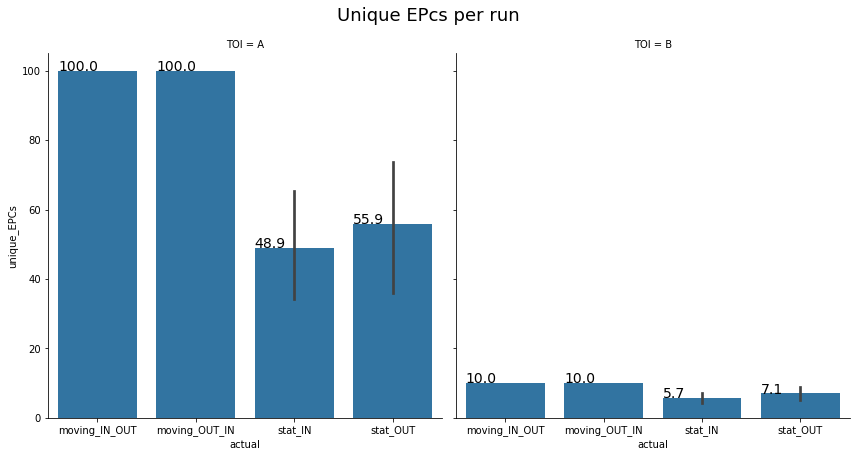

In [35]:
plt.figure(figsize=(8,6))
g = sns.FacetGrid(data=unique_EPCs_run  , height=6, col='TOI') #[ ~unique_EPCs_run['run'].isin(runs_out) ]
g.map_dataframe(sns.barplot, x='actual', y='unique_EPCs', ci=95, order=['moving_IN_OUT', 'moving_OUT_IN', 'stat_IN', 'stat_OUT'])
plt.suptitle('Unique EPcs per run', size=18, y=1.05)
for ax in g.axes.flatten():
    for bar in ax.patches:
        xvar=bar.get_x()
        yvar=bar.get_height()
        ax.annotate(f'{yvar:.1f}', (xvar, yvar), size=14)

## Readcount per EPC per run

In [36]:
ReadCount_EPC_run = tags.groupby(['EPC', 'actual', 'run']).size().rename('rc').reset_index(drop=False)
ReadCount_EPC_run

,EPC,actual,run,rc
0,AD3830770CCDD0AD383001C3,moving_IN_OUT,2022-02-18 17:05:31,11
1,AD3830770CCDD0AD383001C3,moving_IN_OUT,2022-02-18 17:06:31,8
2,AD3830770CCDD0AD383001C3,moving_IN_OUT,2022-02-18 17:07:23,7
3,AD3830770CCDD0AD383001C3,moving_IN_OUT,2022-02-18 17:08:20,8
4,AD3830770CCDD0AD383001C3,moving_IN_OUT,2022-02-18 17:09:10,9
...,...,...,...,...
5862,E28068900000500305C60435,stat_OUT,2022-02-18 17:26:19,13
5863,E28068900000500305C60435,stat_OUT,2022-02-18 17:32:46,17
5864,E28068900000500305C60435,stat_OUT,2022-02-18 17:41:01,22
5865,E28068900000500305C60435,stat_OUT,2022-02-18 17:42:11,2


In [37]:
rc_max=ReadCount_EPC_run['rc'].max()
bins=np.arange(0.5, rc_max+1, 1)
xticks=np.arange(1, rc_max+1)
bins[:3]

array([0.5, 1.5, 2.5])

In [38]:
bins=np.arange(0.5, 10, 1)
xticks=np.arange(1, 10)
bins, xticks

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9]))

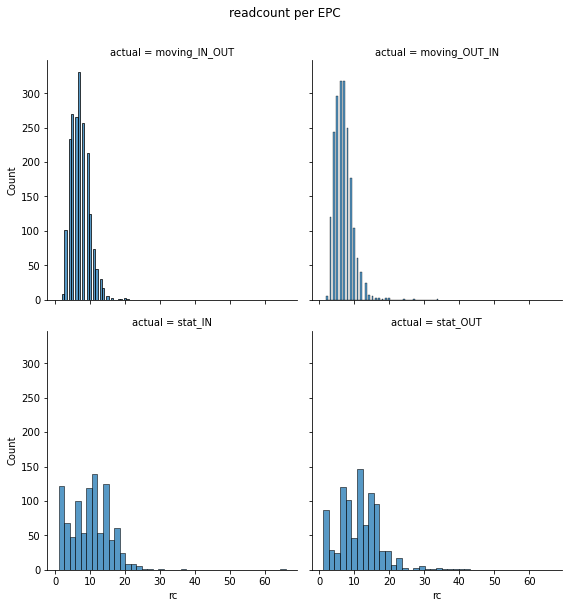

In [39]:
g = sns.FacetGrid(data=ReadCount_EPC_run, col='actual', height=4, col_wrap=2)
Bars = g.map_dataframe(sns.histplot, x='rc')
plt.suptitle('readcount per EPC', y=1.05)
plt.show()

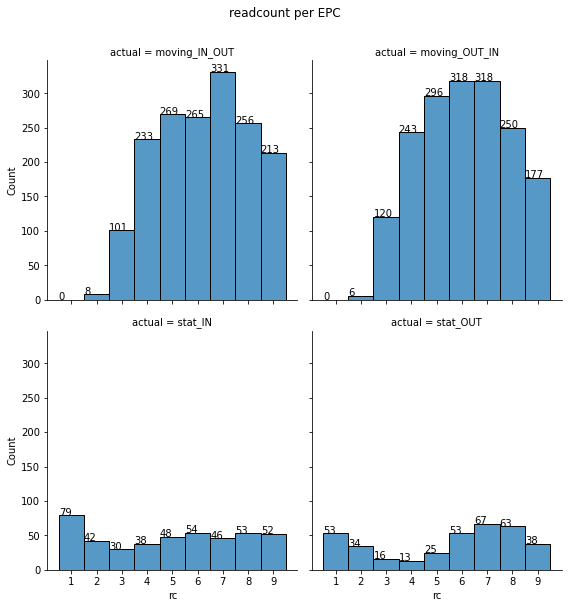

In [40]:
g = sns.FacetGrid(data=ReadCount_EPC_run, col='actual', height=4, col_wrap=2)
Bars = g.map_dataframe(sns.histplot, x='rc', bins=bins)
plt.xticks(xticks)
plt.suptitle('readcount per EPC', y=1.05)
for ax in g.axes.flatten():
    for bar in ax.patches:
        xvar=bar.get_x()
        yvar=bar.get_height()
        ax.annotate(f'{yvar}', (xvar, yvar))
    
plt.show()

## Merge tags to the readcount per EPC per run

In [41]:
tags = pd.merge(tags, ReadCount_EPC_run, on=['run', 'EPC', 'actual'])

In [42]:
tags.head()

,Timestamp,EPC,TID,Antenna,RSSI,Frequency,Hostname,PhaseAngle,DopplerFrequency,hw_conf,...,tag_size,Antenna_coverage,Antenna_zone,Antenna_position,actual,moving_stat,crossing,slotStart,slot_id,rc
0,2022-02-18 16:05:34.800847,AD3830770CCDD0AD38300488,NaN,2,-68.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,15cm2,ain,border_45deg_out,floor,moving_IN_OUT,moving,True,2022-02-18 16:05:34.741807,-9.0,14
1,2022-02-18 16:05:36.517494,AD3830770CCDD0AD38300488,NaN,1,-69.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,15cm2,ain,border_45deg_in,floor,moving_IN_OUT,moving,True,2022-02-18 16:05:35.741807,-8.0,14
2,2022-02-18 16:05:38.240408,AD3830770CCDD0AD38300488,NaN,1,-71.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,15cm2,ain,border_45deg_in,floor,moving_IN_OUT,moving,True,2022-02-18 16:05:37.741807,-6.0,14
3,2022-02-18 16:05:38.264075,AD3830770CCDD0AD38300488,NaN,2,-68.5,865.7,169.254.1.1,NaN,NaN,2in2out,...,15cm2,ain,border_45deg_out,floor,moving_IN_OUT,moving,True,2022-02-18 16:05:37.741807,-6.0,14
4,2022-02-18 16:05:40.107043,AD3830770CCDD0AD38300488,NaN,3,-69.0,865.7,169.254.1.1,NaN,NaN,2in2out,...,15cm2,aout,border_45deg_in,floor,moving_IN_OUT,moving,True,2022-02-18 16:05:39.741807,-4.0,14


## Creating DATASET_DS
sample: run, EPC, slot_id \
features=7: RSSImax, RSSImin, RSSIave, RSSIlinmax, RSSIlinmin, RSSIlinave, rc\
groupby:\
    1- Antenna_coverage=2\
    2- Antenna=4\
    3- all Antennas=1\
==> 7 x (2+4+1)=49 features

### ds_antenna_coverage

In [43]:
ds_rssimax = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna_coverage'])['RSSI'].max().rename('RSSImax')\
                    .unstack('Antenna_coverage')
ds_rssimax.columns = ['RSSImax_'+x for x in ds_rssimax.columns]

ds_rssimin = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna_coverage'])['RSSI'].min().rename('RSSImin')\
                    .unstack('Antenna_coverage')
ds_rssimin.columns = ['RSSImin_'+x for x in ds_rssimin.columns]

ds_rssiave = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna_coverage'])['RSSI'].mean().rename('RSSIave')\
                    .unstack('Antenna_coverage')
ds_rssiave.columns = ['RSSIave_'+x for x in ds_rssiave.columns]

ds_rssilinmax = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna_coverage'])['RSSIlin'].max().rename('RSSIlinmax')\
                    .unstack('Antenna_coverage')
ds_rssilinmax.columns = ['RSSIlinmax_'+x for x in ds_rssilinmax.columns]

ds_rssilinave = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna_coverage'])['RSSIlin'].mean().rename('RSSIlinave')\
                    .unstack('Antenna_coverage')
ds_rssilinave.columns = ['RSSIlinave_'+x for x in ds_rssilinave.columns]

ds_rssilinmin = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna_coverage'])['RSSIlin'].min().rename('RSSIlinmin')\
                    .unstack('Antenna_coverage')
ds_rssilinmin.columns = ['RSSIlinmin_'+x for x in ds_rssilinmin.columns]

ds_rc = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna_coverage']).size().rename('rc')\
                    .unstack('Antenna_coverage')
ds_rc.columns = ['rc_'+x for x in ds_rc.columns]
# 
ds_Antenna_coverage = pd.concat([ds_rssimax, ds_rssiave, ds_rssimin, ds_rssilinmax, ds_rssilinave, ds_rssilinmin, ds_rc], axis=1)
ds_Antenna_coverage[:1]

,,,,,RSSImax_ain,RSSImax_aout,RSSIave_ain,RSSIave_aout,RSSImin_ain,RSSImin_aout,RSSIlinmax_ain,RSSIlinmax_aout,RSSIlinave_ain,RSSIlinave_aout,RSSIlinmin_ain,RSSIlinmin_aout,rc_ain,rc_aout
run,EPC,actual,moving_stat,slot_id,,,,,,,,,,,,,,
2022-02-18 17:05:31,AD3830770CCDD0AD383001C3,moving_IN_OUT,moving,-8.0,-71.0,NaN,-71.0,NaN,-71.0,NaN,0.079433,NaN,0.079433,NaN,0.079433,NaN,1.0,NaN


### ds_antenna

In [44]:
ds_rssimax = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna'])['RSSI'].max().rename('RSSImax')\
                    .unstack('Antenna')
ds_rssimax.columns = ['RSSImax_a'+str(x) for x in ds_rssimax.columns]

ds_rssimin = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna'])['RSSI'].min().rename('RSSImin')\
                    .unstack('Antenna')
ds_rssimin.columns = ['RSSImin_a'+str(x) for x in ds_rssimin.columns]

ds_rssiave = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna'])['RSSI'].mean().rename('RSSIave')\
                    .unstack('Antenna')
ds_rssiave.columns = ['RSSIave_a'+str(x) for x in ds_rssiave.columns]

ds_rssilinmax = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna'])['RSSIlin'].max().rename('RSSIlinmax')\
                    .unstack('Antenna')
ds_rssilinmax.columns = ['RSSIlinmax_a'+str(x) for x in ds_rssilinmax.columns]

ds_rssilinave = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna'])['RSSIlin'].mean().rename('RSSIlinave')\
                    .unstack('Antenna')
ds_rssilinave.columns = ['RSSIlinave_a'+str(x) for x in ds_rssilinave.columns]

ds_rssilinmin = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna'])['RSSIlin'].min().rename('RSSIlinmin')\
                    .unstack('Antenna')
ds_rssilinmin.columns = ['RSSIlinmin_a'+str(x) for x in ds_rssilinmin.columns]

ds_rc = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id', 'Antenna']).size().rename('rc')\
                    .unstack('Antenna')
ds_rc.columns = ['rc_a'+str(x) for x in ds_rc.columns]
# 
ds_Antenna = pd.concat([ds_rssimax, ds_rssiave, ds_rssimin, ds_rssilinmax, ds_rssilinave, ds_rssilinmin, ds_rc], axis=1)
ds_Antenna[:1]

,,,,,RSSImax_a1,RSSImax_a2,RSSImax_a3,RSSImax_a4,RSSIave_a1,RSSIave_a2,RSSIave_a3,RSSIave_a4,RSSImin_a1,RSSImin_a2,...,RSSIlinave_a3,RSSIlinave_a4,RSSIlinmin_a1,RSSIlinmin_a2,RSSIlinmin_a3,RSSIlinmin_a4,rc_a1,rc_a2,rc_a3,rc_a4
run,EPC,actual,moving_stat,slot_id,,,,,,,,,,,,,,,,,,,,,
2022-02-18 17:05:31,AD3830770CCDD0AD383001C3,moving_IN_OUT,moving,-8.0,NaN,-71.0,NaN,NaN,NaN,-71.0,NaN,NaN,NaN,-71.0,...,NaN,NaN,NaN,0.079433,NaN,NaN,NaN,1.0,NaN,NaN


### ds_all_antennas

In [45]:
ds_rssimax = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id'])['RSSI'].max().rename('RSSImax')

ds_rssimin = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id'])['RSSI'].min().rename('RSSImin')

ds_rssiave = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id'])['RSSI'].mean().rename('RSSIave')

ds_rssilinmax = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id'])['RSSIlin'].max().rename('RSSIlinmax')

ds_rssilinave = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id'])['RSSIlin'].mean().rename('RSSIlinave')

ds_rssilinmin = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id'])['RSSIlin'].min().rename('RSSIlinmin')

ds_rc = tags.groupby(['run', 'EPC', 'actual', 'moving_stat', 'slot_id']).size().rename('rc')
# 
ds_all_Antennas = pd.concat([ds_rssimax, ds_rssiave, ds_rssimin, ds_rssilinmax, ds_rssilinave, ds_rssilinmin, ds_rc], axis=1)
ds_all_Antennas[:1]

,,,,,RSSImax,RSSIave,RSSImin,RSSIlinmax,RSSIlinave,RSSIlinmin,rc
run,EPC,actual,moving_stat,slot_id,,,,,,,
2022-02-18 17:05:31,AD3830770CCDD0AD383001C3,moving_IN_OUT,moving,-8.0,-71.0,-71.0,-71.0,0.079433,0.079433,0.079433,1


## DS

In [46]:
ds = pd.concat([ds_Antenna_coverage, ds_Antenna, ds_all_Antennas], axis=1)
Xcols_ds = ds.columns
ds = ds.reset_index(drop=False)
ds.head()

,run,EPC,actual,moving_stat,slot_id,RSSImax_ain,RSSImax_aout,RSSIave_ain,RSSIave_aout,RSSImin_ain,...,rc_a2,rc_a3,rc_a4,RSSImax,RSSIave,RSSImin,RSSIlinmax,RSSIlinave,RSSIlinmin,rc
0,2022-02-18 17:05:31,AD3830770CCDD0AD383001C3,moving_IN_OUT,moving,-8.0,-71.0,NaN,-71.00,NaN,-71.0,...,1.0,NaN,NaN,-71.0,-71.00,-71.0,0.079433,0.079433,0.079433,1
1,2022-02-18 17:05:31,AD3830770CCDD0AD383001C3,moving_IN_OUT,moving,-6.0,-71.0,NaN,-71.25,NaN,-71.5,...,2.0,NaN,NaN,-71.0,-71.25,-71.5,0.079433,0.075114,0.070795,2
2,2022-02-18 17:05:31,AD3830770CCDD0AD383001C3,moving_IN_OUT,moving,-3.0,NaN,-74.5,NaN,-74.5,NaN,...,NaN,1.0,NaN,-74.5,-74.50,-74.5,0.035481,0.035481,0.035481,1
3,2022-02-18 17:05:31,AD3830770CCDD0AD383001C3,moving_IN_OUT,moving,-1.0,-57.0,NaN,-58.75,NaN,-60.5,...,NaN,NaN,NaN,-57.0,-58.75,-60.5,1.995262,1.443257,0.891251,2
4,2022-02-18 17:05:31,AD3830770CCDD0AD383001C3,moving_IN_OUT,moving,0.0,-65.0,NaN,-65.00,NaN,-65.0,...,1.0,NaN,NaN,-65.0,-65.00,-65.0,0.316228,0.316228,0.316228,1


In [47]:
len(Xcols_ds), Xcols_ds

(49,
 Index(['RSSImax_ain', 'RSSImax_aout', 'RSSIave_ain', 'RSSIave_aout',
        'RSSImin_ain', 'RSSImin_aout', 'RSSIlinmax_ain', 'RSSIlinmax_aout',
        'RSSIlinave_ain', 'RSSIlinave_aout', 'RSSIlinmin_ain',
        'RSSIlinmin_aout', 'rc_ain', 'rc_aout', 'RSSImax_a1', 'RSSImax_a2',
        'RSSImax_a3', 'RSSImax_a4', 'RSSIave_a1', 'RSSIave_a2', 'RSSIave_a3',
        'RSSIave_a4', 'RSSImin_a1', 'RSSImin_a2', 'RSSImin_a3', 'RSSImin_a4',
        'RSSIlinmax_a1', 'RSSIlinmax_a2', 'RSSIlinmax_a3', 'RSSIlinmax_a4',
        'RSSIlinave_a1', 'RSSIlinave_a2', 'RSSIlinave_a3', 'RSSIlinave_a4',
        'RSSIlinmin_a1', 'RSSIlinmin_a2', 'RSSIlinmin_a3', 'RSSIlinmin_a4',
        'rc_a1', 'rc_a2', 'rc_a3', 'rc_a4', 'RSSImax', 'RSSIave', 'RSSImin',
        'RSSIlinmax', 'RSSIlinave', 'RSSIlinmin', 'rc'],
       dtype='object'))

### ds fill NAs

In [48]:
# if the value is NA, it means the tag was not detected so we set it to the min RSSI (-85 for linear, 0 for nonlinear)
for col in Xcols_ds:
    if 'RSSI' in col:
        if 'lin' not in col:
            fill_value=-85
        else:
            fill_value=0
    else:
        fill_value=0
    
    ds[col] = ds[col].fillna(fill_value)
ds[:1]

,run,EPC,actual,moving_stat,slot_id,RSSImax_ain,RSSImax_aout,RSSIave_ain,RSSIave_aout,RSSImin_ain,...,rc_a2,rc_a3,rc_a4,RSSImax,RSSIave,RSSImin,RSSIlinmax,RSSIlinave,RSSIlinmin,rc
0,2022-02-18 17:05:31,AD3830770CCDD0AD383001C3,moving_IN_OUT,moving,-8.0,-71.0,-85.0,-71.0,-85.0,-71.0,...,1.0,0.0,0.0,-71.0,-71.0,-71.0,0.079433,0.079433,0.079433,1


In [49]:
ds.shape, len(Xcols_ds)

((41244, 54), 49)

In [50]:
ds.isna().mean().mean()

0.0

### Unstack ds per slot

In [51]:
ds_unstack = ds[['run', 'EPC', 'slot_id']+Xcols_ds.tolist()].set_index(['run', 'EPC', 'slot_id']).unstack('slot_id')
ds_unstack.head()

RSSImax_ain                    \
slot_id                                            -15.0 -14.0 -13.0 -12.0   
run                 EPC                                                      
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3         NaN   NaN   NaN   NaN   
                    AD3830770CCDD0AD383001C8         NaN   NaN   NaN   NaN   
                    AD3830770CCDD0AD383001C9         NaN   NaN   NaN   NaN   
                    AD3830770CCDD0AD383001CB         NaN   NaN   NaN   NaN   
                    AD3830770CCDD0AD383001CE         NaN   NaN   NaN   NaN   

                                                                            \
slot_id                                      -11.0 -10.0 -9.0  -8.0  -7.0    
run                 EPC                                                      
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3   NaN   NaN   NaN -71.0   NaN   
                    AD3830770CCDD0AD383001C8   NaN   NaN -62.5 -61.5   NaN   
                    AD3830770CCDD0AD383001C9   NaN   NaN   NaN -73.5   NaN   
                    AD3830770CCDD0AD383001CB   NaN   NaN -68.0   NaN -66.0   
                    AD3830770CCDD0AD383001CE   NaN   NaN   NaN -73.0   NaN   

                                                    ...    rc              \
slot_id                                      -6.0   ...  2.0   3.0   4.0    
run                 EPC                             ...                     
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3 -71.0  ...   1.0   NaN   1.0   
                    AD3830770CCDD0AD383001C8 -65.0  ...   NaN   1.0   1.0   
                    AD3830770CCDD0AD383001C9 -69.0  ...   NaN   2.0   NaN   
                    AD3830770CCDD0AD383001CB   NaN  ...   1.0   1.0   NaN   
                    AD3830770CCDD0AD383001CE -74.5  ...   1.0   NaN   1.0   

                                                                            \
slot_id                                       5.0   6.0   7.0   8.0   9.0    
run                 EPC                                                      
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3   NaN   1.0   NaN   NaN   NaN   
                    AD3830770CCDD0AD383001C8   NaN   1.0   NaN   NaN   NaN   
                    AD3830770CCDD0AD383001C9   1.0   1.0   NaN   NaN   NaN   
                    AD3830770CCDD0AD383001CB   1.0   1.0   NaN   NaN   NaN   
                    AD3830770CCDD0AD383001CE   NaN   1.0   NaN   NaN   NaN   

                                                          
slot_id                                       10.0  11.0  
run                 EPC                                   
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3   NaN   NaN  
                    AD3830770CCDD0AD383001C8   NaN   NaN  
                    AD3830770CCDD0AD383001C9   NaN   NaN  
                    AD3830770CCDD0AD383001CB   NaN   NaN  
                    AD3830770CCDD0AD383001CE   NaN   NaN  

[5 rows x 1323 columns]

In [52]:
Xcols_ds_unstack = ds_unstack.columns
Xcols_ds_unstack[:3], Xcols_ds_unstack[-3:]

(MultiIndex([('RSSImax_ain', -15.0),
             ('RSSImax_ain', -14.0),
             ('RSSImax_ain', -13.0)],
            names=[None, 'slot_id']),
 MultiIndex([('rc',  9.0),
             ('rc', 10.0),
             ('rc', 11.0)],
            names=[None, 'slot_id']))

In [53]:
ds_unstack.isna().mean().mean()

0.7396360055299882

In [54]:
# if the value is NA, it means the tag was not detected so we set it to the min RSSI (-85 for linear, 0 for nonlinear)
for col in Xcols_ds_unstack:
    feature=col[0]
    if 'RSSI' in feature:
        if 'lin' not in feature:
            fill_value=-85
        else:
            fill_value=0
    else:
        fill_value=0
    
    ds_unstack[col] = ds_unstack[col].fillna(fill_value)
ds_unstack.head()

RSSImax_ain                    \
slot_id                                            -15.0 -14.0 -13.0 -12.0   
run                 EPC                                                      
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3       -85.0 -85.0 -85.0 -85.0   
                    AD3830770CCDD0AD383001C8       -85.0 -85.0 -85.0 -85.0   
                    AD3830770CCDD0AD383001C9       -85.0 -85.0 -85.0 -85.0   
                    AD3830770CCDD0AD383001CB       -85.0 -85.0 -85.0 -85.0   
                    AD3830770CCDD0AD383001CE       -85.0 -85.0 -85.0 -85.0   

                                                                            \
slot_id                                      -11.0 -10.0 -9.0  -8.0  -7.0    
run                 EPC                                                      
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3 -85.0 -85.0 -85.0 -71.0 -85.0   
                    AD3830770CCDD0AD383001C8 -85.0 -85.0 -62.5 -61.5 -85.0   
                    AD3830770CCDD0AD383001C9 -85.0 -85.0 -85.0 -73.5 -85.0   
                    AD3830770CCDD0AD383001CB -85.0 -85.0 -68.0 -85.0 -66.0   
                    AD3830770CCDD0AD383001CE -85.0 -85.0 -85.0 -73.0 -85.0   

                                                    ...    rc              \
slot_id                                      -6.0   ...  2.0   3.0   4.0    
run                 EPC                             ...                     
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3 -71.0  ...   1.0   0.0   1.0   
                    AD3830770CCDD0AD383001C8 -65.0  ...   0.0   1.0   1.0   
                    AD3830770CCDD0AD383001C9 -69.0  ...   0.0   2.0   0.0   
                    AD3830770CCDD0AD383001CB -85.0  ...   1.0   1.0   0.0   
                    AD3830770CCDD0AD383001CE -74.5  ...   1.0   0.0   1.0   

                                                                            \
slot_id                                       5.0   6.0   7.0   8.0   9.0    
run                 EPC                                                      
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3   0.0   1.0   0.0   0.0   0.0   
                    AD3830770CCDD0AD383001C8   0.0   1.0   0.0   0.0   0.0   
                    AD3830770CCDD0AD383001C9   1.0   1.0   0.0   0.0   0.0   
                    AD3830770CCDD0AD383001CB   1.0   1.0   0.0   0.0   0.0   
                    AD3830770CCDD0AD383001CE   0.0   1.0   0.0   0.0   0.0   

                                                          
slot_id                                       10.0  11.0  
run                 EPC                                   
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3   0.0   0.0  
                    AD3830770CCDD0AD383001C8   0.0   0.0  
                    AD3830770CCDD0AD383001C9   0.0   0.0  
                    AD3830770CCDD0AD383001CB   0.0   0.0  
                    AD3830770CCDD0AD383001CE   0.0   0.0  

[5 rows x 1323 columns]

### ds for rolling window

In [55]:
slot_id_min = ds['slot_id'].min()
slot_id_max = ds['slot_id'].max()
slot_id_min, slot_id_max

(-15.0, 11.0)

In [56]:
window=4 # take rolling window as 4 consecutive slots
slotStarts = np.arange(slot_id_min, slot_id_max-window+2)
slotStarts

array([-15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,
        -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,
         7.,   8.])

In [57]:
rollingwindow_list = [ (np.arange(x, x+window)) for x in slotStarts]
rollingwindow_list[:2], rollingwindow_list[-2:]

([array([-15., -14., -13., -12.]), array([-14., -13., -12., -11.])],
 [array([ 7.,  8.,  9., 10.]), array([ 8.,  9., 10., 11.])])

In [58]:
len(rollingwindow_list)

24

In [59]:
func_window_feature={\
             'rc':np.sum, \
             'RSSIlinmax':np.max, 'RSSImax':np.max, \
             'RSSIlinave':np.mean, 'RSSIave':np.mean,\
             'RSSIlinmin':np.min, 'RSSImin':np.min}

In [60]:
ds_rolling=pd.DataFrame()
for rollingwindow in rollingwindow_list:
    rollingwindow_str = [f'{x:.0f}' for x in rollingwindow]
    rollingwindow_str = '_'.join(rollingwindow_str)
    print(rollingwindow_str)
    Xcols_rollingwindow = [x for x in Xcols_ds_unstack for i in range(len(rollingwindow)) if x[1]==rollingwindow[i] ]
    ds_rollingwindow = ds_unstack[Xcols_rollingwindow]
    dict_slot_renaming = dict(zip(rollingwindow, np.arange(len(rollingwindow))))
    Xcols_rollingwindow_rename = [ (x[0], dict_slot_renaming[x[1]]) for x in ds_rollingwindow.columns]
    Xcols_rollingwindow_rename = [f'{x[0]}_{x[1]:.0f}' for x in Xcols_rollingwindow_rename]
    ds_rollingwindow.columns = Xcols_rollingwindow_rename
# 
    
    for col in Xcols_ds:
        Xcols_rolling = [x for x in Xcols_rollingwindow_rename if col in x ]
        col_window=f'{col}_window'
        for feature in func_window_feature.keys():
            if feature in col:
                func_window = func_window_feature[feature]
        ds_rollingwindow.loc [:, col_window] = func_window(ds_rollingwindow.loc [:, Xcols_rolling], axis=1)
        
    ds_rollingwindow.loc[:, 'window']= rollingwindow_str
    ds_rolling = ds_rolling.append(ds_rollingwindow)

-15_-14_-13_-12


C:\Users\Acer\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


-14_-13_-12_-11
-13_-12_-11_-10
-12_-11_-10_-9
-11_-10_-9_-8
-10_-9_-8_-7
-9_-8_-7_-6
-8_-7_-6_-5
-7_-6_-5_-4
-6_-5_-4_-3
-5_-4_-3_-2
-4_-3_-2_-1
-3_-2_-1_0
-2_-1_0_1
-1_0_1_2
0_1_2_3
1_2_3_4
2_3_4_5
3_4_5_6
4_5_6_7
5_6_7_8
6_7_8_9
7_8_9_10
8_9_10_11


In [61]:
ds_rolling.head()

RSSImax_ain_0  RSSImax_ain_1  \
run                 EPC                                                      
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3          -85.0          -85.0   
                    AD3830770CCDD0AD383001C8          -85.0          -85.0   
                    AD3830770CCDD0AD383001C9          -85.0          -85.0   
                    AD3830770CCDD0AD383001CB          -85.0          -85.0   
                    AD3830770CCDD0AD383001CE          -85.0          -85.0   

                                              RSSImax_ain_2  RSSImax_ain_3  \
run                 EPC                                                      
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3          -85.0          -85.0   
                    AD3830770CCDD0AD383001C8          -85.0          -85.0   
                    AD3830770CCDD0AD383001C9          -85.0          -85.0   
                    AD3830770CCDD0AD383001CB          -85.0          -85.0   
                    AD3830770CCDD0AD383001CE          -85.0          -85.0   

                                              RSSImax_aout_0  RSSImax_aout_1  \
run                 EPC                                                        
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3           -85.0           -85.0   
                    AD3830770CCDD0AD383001C8           -85.0           -85.0   
                    AD3830770CCDD0AD383001C9           -85.0           -85.0   
                    AD3830770CCDD0AD383001CB           -85.0           -85.0   
                    AD3830770CCDD0AD383001CE           -85.0           -85.0   

                                              RSSImax_aout_2  RSSImax_aout_3  \
run                 EPC                                                        
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3           -85.0           -85.0   
                    AD3830770CCDD0AD383001C8           -85.0           -85.0   
                    AD3830770CCDD0AD383001C9           -85.0           -85.0   
                    AD3830770CCDD0AD383001CB           -85.0           -85.0   
                    AD3830770CCDD0AD383001CE           -85.0           -85.0   

                                              RSSIave_ain_0  RSSIave_ain_1  \
run                 EPC                                                      
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3          -85.0          -85.0   
                    AD3830770CCDD0AD383001C8          -85.0          -85.0   
                    AD3830770CCDD0AD383001C9          -85.0          -85.0   
                    AD3830770CCDD0AD383001CB          -85.0          -85.0   
                    AD3830770CCDD0AD383001CE          -85.0          -85.0   

                                              ...  rc_a3_window  rc_a4_window  \
run                 EPC                       ...                               
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3  ...           0.0           0.0   
                    AD3830770CCDD0AD383001C8  ...           0.0           0.0   
                    AD3830770CCDD0AD383001C9  ...           0.0           0.0   
                    AD3830770CCDD0AD383001CB  ...           0.0           0.0   
                    AD3830770CCDD0AD383001CE  ...           0.0           0.0   

                                              RSSImax_window  RSSIave_window  \
run                 EPC                                                        
2022-02-18 17:05:31 AD3830770CCDD0AD383001C3           -85.0           -85.0   
                    AD3830770CCDD0AD383001C8           -85.0           -85.0   
                    AD3830770CCDD0AD383001C9           -85.0           -85.0   
                    AD3830770CCDD0AD383001CB           -85.0           -85.0   
                    AD3830770CCDD0AD383001CE           -85.0           -85.0   

                                              RSSImin_window  \
run                 EPC                                        
2022-02-18 17:05:31 AD3830

In [62]:
Xcols_ds_rolling = [x for x in ds_rolling.columns if x!='window']
Xcols_ds_rolling[:3], Xcols_ds_rolling[-3:]

(['RSSImax_ain_0', 'RSSImax_ain_1', 'RSSImax_ain_2'],
 ['RSSIlinave_window', 'RSSIlinmin_window', 'rc_window'])

In [63]:
len(Xcols_ds_rolling)

245

In [64]:
ds_rolling = ds_rolling.reset_index(drop=False)
ds_rolling = ds_rolling [['run', 'EPC', 'window']+Xcols_ds_rolling]
ds_rolling.head()

,run,EPC,window,RSSImax_ain_0,RSSImax_ain_1,RSSImax_ain_2,RSSImax_ain_3,RSSImax_aout_0,RSSImax_aout_1,RSSImax_aout_2,...,rc_a2_window,rc_a3_window,rc_a4_window,RSSImax_window,RSSIave_window,RSSImin_window,RSSIlinmax_window,RSSIlinave_window,RSSIlinmin_window,rc_window
0,2022-02-18 17:05:31,AD3830770CCDD0AD383001C3,-15_-14_-13_-12,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,-85.0,-85.0,-85.0,0.0,0.0,0.0,0.0
1,2022-02-18 17:05:31,AD3830770CCDD0AD383001C8,-15_-14_-13_-12,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,-85.0,-85.0,-85.0,0.0,0.0,0.0,0.0
2,2022-02-18 17:05:31,AD3830770CCDD0AD383001C9,-15_-14_-13_-12,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,-85.0,-85.0,-85.0,0.0,0.0,0.0,0.0
3,2022-02-18 17:05:31,AD3830770CCDD0AD383001CB,-15_-14_-13_-12,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,-85.0,-85.0,-85.0,0.0,0.0,0.0,0.0
4,2022-02-18 17:05:31,AD3830770CCDD0AD383001CE,-15_-14_-13_-12,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,-85.0,-85.0,-85.0,0.0,0.0,0.0,0.0


In [65]:
ds_unstack.shape, ds_rolling['window'].nunique(), ds_rolling.shape, len(Xcols_ds_rolling)

((5867, 1323), 24, (140808, 248), 245)

In [66]:
(ds_rolling['rc_window']==0).sum()

63136

In [67]:
ds_rolling.shape, ds_rolling [ds_rolling['rc_window']!=0].shape

((140808, 248), (77672, 248))

In [68]:
ds_rolling = ds_rolling [ds_rolling['rc_window']!=0].reset_index(drop=True)
ds_rolling[:1]

,run,EPC,window,RSSImax_ain_0,RSSImax_ain_1,RSSImax_ain_2,RSSImax_ain_3,RSSImax_aout_0,RSSImax_aout_1,RSSImax_aout_2,...,rc_a2_window,rc_a3_window,rc_a4_window,RSSImax_window,RSSIave_window,RSSImin_window,RSSIlinmax_window,RSSIlinave_window,RSSIlinmin_window,rc_window
0,2022-02-18 17:32:46,AD3830770CCDD0AD383001FA,-15_-14_-13_-12,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,1.0,-72.5,-83.660714,-85.0,0.056234,0.006025,0.0,3.0


In [69]:
ds_rolling.shape, len(Xcols_ds_rolling)

((77672, 248), 245)

### Keep only the rows where static tags are 3m or more away from dock door

In [70]:
ds_rolling_pick = pd.merge(ds_rolling, runs[['run', 'keep_out', 'moving_TOI', 'moving_motion']], on='run')
ds_rolling_pick = ds_rolling_pick [['run', 'EPC', 'window', 'keep_out', 'moving_TOI', 'moving_motion']+Xcols_ds_rolling]
# 
ds_rolling_pick = ds_rolling_pick [(ds_rolling_pick['keep_out']>=3)].reset_index(drop=True)
# 
ds_rolling_pick.head()

,run,EPC,window,keep_out,moving_TOI,moving_motion,RSSImax_ain_0,RSSImax_ain_1,RSSImax_ain_2,RSSImax_ain_3,...,rc_a2_window,rc_a3_window,rc_a4_window,RSSImax_window,RSSIave_window,RSSImin_window,RSSIlinmax_window,RSSIlinave_window,RSSIlinmin_window,rc_window
0,2022-02-18 17:46:48,E28068900000400305C60434,-15_-14_-13_-12,5.0,A,OUT_IN,-85.0,-74.5,-85.0,-74.5,...,0.0,0.0,0.0,-74.5,-82.750000,-85.0,0.035481,0.007603,0.0,6.0
1,2022-02-18 17:46:48,E28068900000500305C60435,-15_-14_-13_-12,5.0,A,OUT_IN,-85.0,-85.0,-80.0,-85.0,...,0.0,0.0,0.0,-80.0,-84.464286,-85.0,0.010000,0.001071,0.0,3.0
2,2022-02-18 17:46:48,E28068900000400305C60434,-14_-13_-12_-11,5.0,A,OUT_IN,-74.5,-85.0,-74.5,-85.0,...,0.0,0.0,0.0,-74.5,-82.750000,-85.0,0.035481,0.007603,0.0,6.0
3,2022-02-18 17:46:48,E28068900000500305C6042D,-14_-13_-12_-11,5.0,A,OUT_IN,-85.0,-85.0,-85.0,-74.5,...,1.0,0.0,0.0,-74.5,-83.875000,-85.0,0.035481,0.003802,0.0,3.0
4,2022-02-18 17:46:48,E28068900000500305C60435,-14_-13_-12_-11,5.0,A,OUT_IN,-85.0,-80.0,-85.0,-79.5,...,0.0,0.0,0.0,-79.5,-83.875000,-85.0,0.011220,0.002274,0.0,6.0


In [71]:
(ds_rolling_pick['rc_window']==0).mean()

0.0

### ds_EPC

In [72]:
crossing_window = np.arange(-int(window/2), int(window/2), 1)
crossing_window = [str(x) for x in crossing_window]
crossing_window = '_'.join(crossing_window)
crossing_window

'-2_-1_0_1'

In [73]:
ds_EPC = ds_rolling_pick [ ds_rolling_pick['window'] == crossing_window ]
Xcols_ds_EPC = Xcols_ds_rolling

ds_EPC = ds_EPC.reset_index(drop=True)
ds_EPC.head()

,run,EPC,window,keep_out,moving_TOI,moving_motion,RSSImax_ain_0,RSSImax_ain_1,RSSImax_ain_2,RSSImax_ain_3,...,rc_a2_window,rc_a3_window,rc_a4_window,RSSImax_window,RSSIave_window,RSSImin_window,RSSIlinmax_window,RSSIlinave_window,RSSIlinmin_window,rc_window
0,2022-02-18 17:46:48,AD3830770CCDD0AD383001C3,-2_-1_0_1,5.0,A,OUT_IN,-85.0,-66.0,-85.0,-72.5,...,2.0,1.0,0.0,-66.0,-79.910714,-85.0,0.251189,0.046427,0.0,9.0
1,2022-02-18 17:46:48,AD3830770CCDD0AD383001C8,-2_-1_0_1,5.0,A,OUT_IN,-66.5,-85.0,-85.0,-58.0,...,1.0,1.0,1.0,-58.0,-77.437500,-85.0,1.584893,0.192505,0.0,12.0
2,2022-02-18 17:46:48,AD3830770CCDD0AD383001C9,-2_-1_0_1,5.0,A,OUT_IN,-85.0,-85.0,-62.0,-65.5,...,2.0,1.0,0.0,-62.0,-78.196429,-85.0,0.630957,0.140454,0.0,9.0
3,2022-02-18 17:46:48,AD3830770CCDD0AD383001CB,-2_-1_0_1,5.0,A,OUT_IN,-85.0,-73.0,-85.0,-85.0,...,0.0,2.0,0.0,-63.5,-81.678571,-85.0,0.446684,0.036867,0.0,9.0
4,2022-02-18 17:46:48,AD3830770CCDD0AD383001CE,-2_-1_0_1,5.0,A,OUT_IN,-85.0,-85.0,-85.0,-66.5,...,1.0,2.0,1.0,-55.0,-75.732143,-85.0,3.162278,0.422437,0.0,12.0


In [74]:
len(Xcols_ds_EPC)

245

In [75]:
ds_EPC = pd.merge(ds_EPC, reflist[['EPC', 'TOI']], on='EPC')

for i, row in runs.iterrows():
    run=row['run']
    moving_TOI=row['moving_TOI']
    moving_motion=row['moving_motion']
    stat_TOI=row['stat_TOI']
    stat_zone=row['stat_zone']
    actual_moving = 'moving_'+ moving_motion
    actual_stat = 'stat_' + stat_zone
#     
    ds_EPC_run = ds_EPC [ ds_EPC['run'] == run ]
    index_ds_EPC_run = ds_EPC_run.index
    crit = (ds_EPC_run['TOI'] == moving_TOI)
    ds_EPC.loc[index_ds_EPC_run,'actual'] = np.where(crit, actual_moving, actual_stat)
ds_EPC.head()

,run,EPC,window,keep_out,moving_TOI,moving_motion,RSSImax_ain_0,RSSImax_ain_1,RSSImax_ain_2,RSSImax_ain_3,...,rc_a4_window,RSSImax_window,RSSIave_window,RSSImin_window,RSSIlinmax_window,RSSIlinave_window,RSSIlinmin_window,rc_window,TOI,actual
0,2022-02-18 17:46:48,AD3830770CCDD0AD383001C3,-2_-1_0_1,5.0,A,OUT_IN,-85.0,-66.0,-85.0,-72.5,...,0.0,-66.0,-79.910714,-85.0,0.251189,0.046427,0.0,9.0,A,moving_OUT_IN
1,2022-02-18 17:45:38,AD3830770CCDD0AD383001C3,-2_-1_0_1,3.0,A,OUT_IN,-70.0,-85.0,-58.5,-69.0,...,2.0,-58.5,-75.443452,-85.0,1.412538,0.224471,0.0,21.0,A,moving_OUT_IN
2,2022-02-18 17:23:09,AD3830770CCDD0AD383001C3,-2_-1_0_1,3.0,A,IN_OUT,-61.0,-66.0,-85.0,-85.0,...,1.0,-61.0,-78.035714,-85.0,0.794328,0.165718,0.0,9.0,A,moving_IN_OUT
3,2022-02-18 17:28:27,AD3830770CCDD0AD383001C3,-2_-1_0_1,3.0,A,IN_OUT,-85.0,-59.5,-68.5,-74.0,...,0.0,-59.5,-79.321429,-85.0,1.122018,0.139616,0.0,9.0,A,moving_IN_OUT
4,2022-02-18 17:30:42,AD3830770CCDD0AD383001C3,-2_-1_0_1,3.0,A,OUT_IN,-85.0,-69.0,-85.0,-67.0,...,1.0,-66.5,-79.375000,-85.0,0.223872,0.058853,0.0,9.0,A,moving_OUT_IN


In [76]:
ds_EPC ['moving_stat'] = ds_EPC['actual'].apply(lambda x:x.split('_')[0])

ds_EPC = ds_EPC [['run', 'EPC', 'window', 'TOI', 'moving_stat', 'actual']+ Xcols_ds_EPC]

ds_EPC.head()

,run,EPC,window,TOI,moving_stat,actual,RSSImax_ain_0,RSSImax_ain_1,RSSImax_ain_2,RSSImax_ain_3,...,rc_a2_window,rc_a3_window,rc_a4_window,RSSImax_window,RSSIave_window,RSSImin_window,RSSIlinmax_window,RSSIlinave_window,RSSIlinmin_window,rc_window
0,2022-02-18 17:46:48,AD3830770CCDD0AD383001C3,-2_-1_0_1,A,moving,moving_OUT_IN,-85.0,-66.0,-85.0,-72.5,...,2.0,1.0,0.0,-66.0,-79.910714,-85.0,0.251189,0.046427,0.0,9.0
1,2022-02-18 17:45:38,AD3830770CCDD0AD383001C3,-2_-1_0_1,A,moving,moving_OUT_IN,-70.0,-85.0,-58.5,-69.0,...,3.0,1.0,2.0,-58.5,-75.443452,-85.0,1.412538,0.224471,0.0,21.0
2,2022-02-18 17:23:09,AD3830770CCDD0AD383001C3,-2_-1_0_1,A,moving,moving_IN_OUT,-61.0,-66.0,-85.0,-85.0,...,2.0,0.0,1.0,-61.0,-78.035714,-85.0,0.794328,0.165718,0.0,9.0
3,2022-02-18 17:28:27,AD3830770CCDD0AD383001C3,-2_-1_0_1,A,moving,moving_IN_OUT,-85.0,-59.5,-68.5,-74.0,...,1.0,0.0,0.0,-59.5,-79.321429,-85.0,1.122018,0.139616,0.0,9.0
4,2022-02-18 17:30:42,AD3830770CCDD0AD383001C3,-2_-1_0_1,A,moving,moving_OUT_IN,-85.0,-69.0,-85.0,-67.0,...,0.0,0.0,1.0,-66.5,-79.375000,-85.0,0.223872,0.058853,0.0,9.0


In [77]:
ds_EPC.groupby('moving_stat').size()

moving_stat
moving    1760
stat       376
dtype: int64

In [78]:
ds_EPC.shape, ds_EPC [ ds_EPC['rc_window']!=0 ].shape

((2136, 251), (2136, 251))

In [79]:
Xcols_ds_EPC_lin = [x for x in Xcols_ds_EPC if ('RSSIlin' in x) | ('RSSI' not in x) ]
len(Xcols_ds_EPC_lin), len(Xcols_ds_EPC)

(140, 245)

In [80]:
ds_EPC.head()

,run,EPC,window,TOI,moving_stat,actual,RSSImax_ain_0,RSSImax_ain_1,RSSImax_ain_2,RSSImax_ain_3,...,rc_a2_window,rc_a3_window,rc_a4_window,RSSImax_window,RSSIave_window,RSSImin_window,RSSIlinmax_window,RSSIlinave_window,RSSIlinmin_window,rc_window
0,2022-02-18 17:46:48,AD3830770CCDD0AD383001C3,-2_-1_0_1,A,moving,moving_OUT_IN,-85.0,-66.0,-85.0,-72.5,...,2.0,1.0,0.0,-66.0,-79.910714,-85.0,0.251189,0.046427,0.0,9.0
1,2022-02-18 17:45:38,AD3830770CCDD0AD383001C3,-2_-1_0_1,A,moving,moving_OUT_IN,-70.0,-85.0,-58.5,-69.0,...,3.0,1.0,2.0,-58.5,-75.443452,-85.0,1.412538,0.224471,0.0,21.0
2,2022-02-18 17:23:09,AD3830770CCDD0AD383001C3,-2_-1_0_1,A,moving,moving_IN_OUT,-61.0,-66.0,-85.0,-85.0,...,2.0,0.0,1.0,-61.0,-78.035714,-85.0,0.794328,0.165718,0.0,9.0
3,2022-02-18 17:28:27,AD3830770CCDD0AD383001C3,-2_-1_0_1,A,moving,moving_IN_OUT,-85.0,-59.5,-68.5,-74.0,...,1.0,0.0,0.0,-59.5,-79.321429,-85.0,1.122018,0.139616,0.0,9.0
4,2022-02-18 17:30:42,AD3830770CCDD0AD383001C3,-2_-1_0_1,A,moving,moving_OUT_IN,-85.0,-69.0,-85.0,-67.0,...,0.0,0.0,1.0,-66.5,-79.375000,-85.0,0.223872,0.058853,0.0,9.0


In [81]:
Xcols_ds_EPC_lin

['RSSIlinmax_ain_0',
 'RSSIlinmax_ain_1',
 'RSSIlinmax_ain_2',
 'RSSIlinmax_ain_3',
 'RSSIlinmax_aout_0',
 'RSSIlinmax_aout_1',
 'RSSIlinmax_aout_2',
 'RSSIlinmax_aout_3',
 'RSSIlinave_ain_0',
 'RSSIlinave_ain_1',
 'RSSIlinave_ain_2',
 'RSSIlinave_ain_3',
 'RSSIlinave_aout_0',
 'RSSIlinave_aout_1',
 'RSSIlinave_aout_2',
 'RSSIlinave_aout_3',
 'RSSIlinmin_ain_0',
 'RSSIlinmin_ain_1',
 'RSSIlinmin_ain_2',
 'RSSIlinmin_ain_3',
 'RSSIlinmin_aout_0',
 'RSSIlinmin_aout_1',
 'RSSIlinmin_aout_2',
 'RSSIlinmin_aout_3',
 'rc_ain_0',
 'rc_ain_1',
 'rc_ain_2',
 'rc_ain_3',
 'rc_aout_0',
 'rc_aout_1',
 'rc_aout_2',
 'rc_aout_3',
 'RSSIlinmax_a1_0',
 'RSSIlinmax_a1_1',
 'RSSIlinmax_a1_2',
 'RSSIlinmax_a1_3',
 'RSSIlinmax_a2_0',
 'RSSIlinmax_a2_1',
 'RSSIlinmax_a2_2',
 'RSSIlinmax_a2_3',
 'RSSIlinmax_a3_0',
 'RSSIlinmax_a3_1',
 'RSSIlinmax_a3_2',
 'RSSIlinmax_a3_3',
 'RSSIlinmax_a4_0',
 'RSSIlinmax_a4_1',
 'RSSIlinmax_a4_2',
 'RSSIlinmax_a4_3',
 'RSSIlinave_a1_0',
 'RSSIlinave_a1_1',
 'RSSIlinave_a1_

## MACHINE LEARNING

### TASK 1
Determine if tags are moving or static:

In [82]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

In [83]:
X = ds_EPC.loc[:, Xcols_ds_EPC_lin] 
y = ds_EPC.loc[:, 'moving_stat']

In [84]:
y.value_counts()

moving    1760
stat       376
Name: moving_stat, dtype: int64

In [85]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)

#### SVM:

In [86]:
clf=SVC
param_grid = {'C':[10], 'gamma':[0.01], 'kernel':['rbf']} # best hyper-params after tuning with grid search
gs = GridSearchCV(clf(), param_grid, cv=10)

gs.fit(Xtrain, ytrain)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [10], 'gamma': [0.01], 'kernel': ['rbf']})

In [87]:
ypred = gs.predict(Xtest)

In [88]:
target_names = ['moving', 'stat']

              precision    recall  f1-score   support

      moving       0.99      0.98      0.98       585
        stat       0.91      0.94      0.93       120

    accuracy                           0.97       705
   macro avg       0.95      0.96      0.96       705
weighted avg       0.97      0.97      0.97       705

0.9744680851063829
0.9749030438845292
0.9744680851063829
0.9746335690751983
[[574  11]
 [  7 113]]


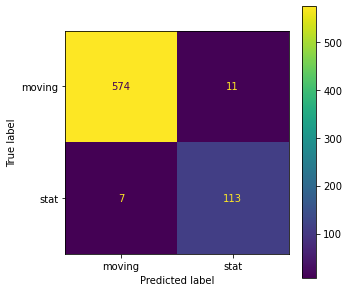

In [89]:
print(classification_report(ytest, ypred, target_names=target_names))

print(recall_score(ytest, ypred, average='weighted'))
print(precision_score(ytest, ypred, average='weighted'))
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred, average='weighted'))
print(confusion_matrix(ytest, ypred, labels=target_names))

fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(gs, Xtest, ytest, ax=ax)

#### kNN:

              precision    recall  f1-score   support

      moving       0.97      0.96      0.96       585
        stat       0.81      0.87      0.84       120

    accuracy                           0.94       705
   macro avg       0.89      0.91      0.90       705
weighted avg       0.94      0.94      0.94       705

0.9418439716312057
0.9439633844631371
0.9418439716312057
0.9426695732294177
[[560  25]
 [ 16 104]]


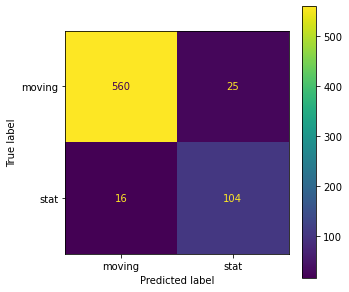

In [90]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(Xtrain, ytrain)

ypred = clf.predict(Xtest)

print(classification_report(ytest, ypred, target_names=target_names))

print(recall_score(ytest, ypred, average='weighted'))
print(precision_score(ytest, ypred, average='weighted'))
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred, average='weighted'))
print(confusion_matrix(ytest, ypred, labels=target_names))
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(clf, Xtest, ytest, ax=ax)

              precision    recall  f1-score   support

      moving       0.98      0.96      0.97       585
        stat       0.82      0.88      0.85       120

    accuracy                           0.95       705
   macro avg       0.90      0.92      0.91       705
weighted avg       0.95      0.95      0.95       705

0.9460992907801419
0.9483725894826727
0.9460992907801419
0.9469449743213499
[[561  24]
 [ 14 106]]


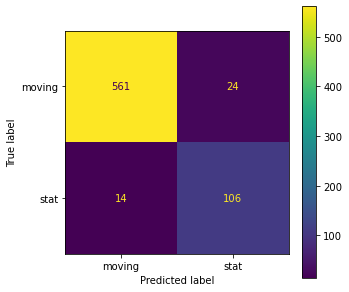

In [91]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(Xtrain, ytrain)

ypred = clf.predict(Xtest)

print(classification_report(ytest, ypred, target_names=target_names))

print(recall_score(ytest, ypred, average='weighted'))
print(precision_score(ytest, ypred, average='weighted'))
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred, average='weighted'))
print(confusion_matrix(ytest, ypred, labels=target_names))
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(clf, Xtest, ytest, ax=ax)

#### XGBoost:

              precision    recall  f1-score   support

      moving       0.98      0.99      0.99       585
        stat       0.96      0.91      0.94       120

    accuracy                           0.98       705
   macro avg       0.97      0.95      0.96       705
weighted avg       0.98      0.98      0.98       705

0.9787234042553191
0.9785564254708485
0.9787234042553191
0.9784670681409511
[[581   4]
 [ 11 109]]


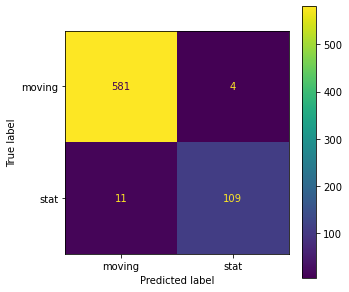

In [92]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

print(classification_report(ytest, ypred, target_names=target_names))

print(recall_score(ytest, ypred, average='weighted'))
print(precision_score(ytest, ypred, average='weighted'))
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred, average='weighted'))
print(confusion_matrix(ytest, ypred, labels=target_names))
fig, ax = plt.subplots(figsize=(5, 5))
plot_confusion_matrix(clf, Xtest, ytest, ax=ax)

#### Deep learning:

In [93]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [94]:
X_train = Xtrain
X_test = Xtest

y_train = ytrain.values
y_test = ytest.values

In [95]:
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [96]:
ohe = OneHotEncoder(handle_unknown="ignore")
print(y_train.shape)
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_train = y_train.toarray()
print(y_train.shape)

print(y_test.shape)
y_test = ohe.transform(y_test.reshape(-1,1))
y_test = y_test.toarray()
print(y_test.shape)

(1431,)
(1431, 2)
(705,)
(705, 2)


In [97]:
input_shape = X_train.shape[1]

inputs = keras.Input(shape=(input_shape, )) # best parameters after grid search
x = Dense(32, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(rate = 0.25)(x)
outputs = Dense(2, activation='softmax')(x)

model = keras.Model(inputs, outputs)

opt = Adam(learning_rate=0.0001)

model.compile(optimizer = opt, loss = 'accuracy')

callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.005, patience=30,
                                verbose=2, mode='max', restore_best_weights=True)
                 ]

model.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer='adam') # metrics can be a list of more than 1
history = model.fit(X_train, y_train, validation_split = 0.1, callbacks=callbacks_list,
                    batch_size=128, epochs=200)

Epoch 1/200
11/11 [==============================] - 1s 25ms/step - loss: 0.6799 - accuracy: 0.5796 - val_loss: 0.5891 - val_accuracy: 0.8264
Epoch 2/200
11/11 [==============================] - 0s 4ms/step - loss: 0.5376 - accuracy: 0.8197 - val_loss: 0.4476 - val_accuracy: 0.8264
Epoch 3/200
11/11 [==============================] - 0s 4ms/step - loss: 0.4355 - accuracy: 0.8205 - val_loss: 0.3663 - val_accuracy: 0.8264
Epoch 4/200
11/11 [==============================] - 0s 6ms/step - loss: 0.4025 - accuracy: 0.8205 - val_loss: 0.3466 - val_accuracy: 0.8264
Epoch 5/200
11/11 [==============================] - 0s 6ms/step - loss: 0.3905 - accuracy: 0.8205 - val_loss: 0.3322 - val_accuracy: 0.8264
Epoch 6/200
11/11 [==============================] - 0s 5ms/step - loss: 0.3653 - accuracy: 0.8205 - val_loss: 0.3189 - val_accuracy: 0.8264
Epoch 7/200
11/11 [==============================] - 0s 5ms/step - loss: 0.3421 - accuracy: 0.8205 - val_loss: 0.3021 - val_accuracy: 0.8264
Epoch 8/200


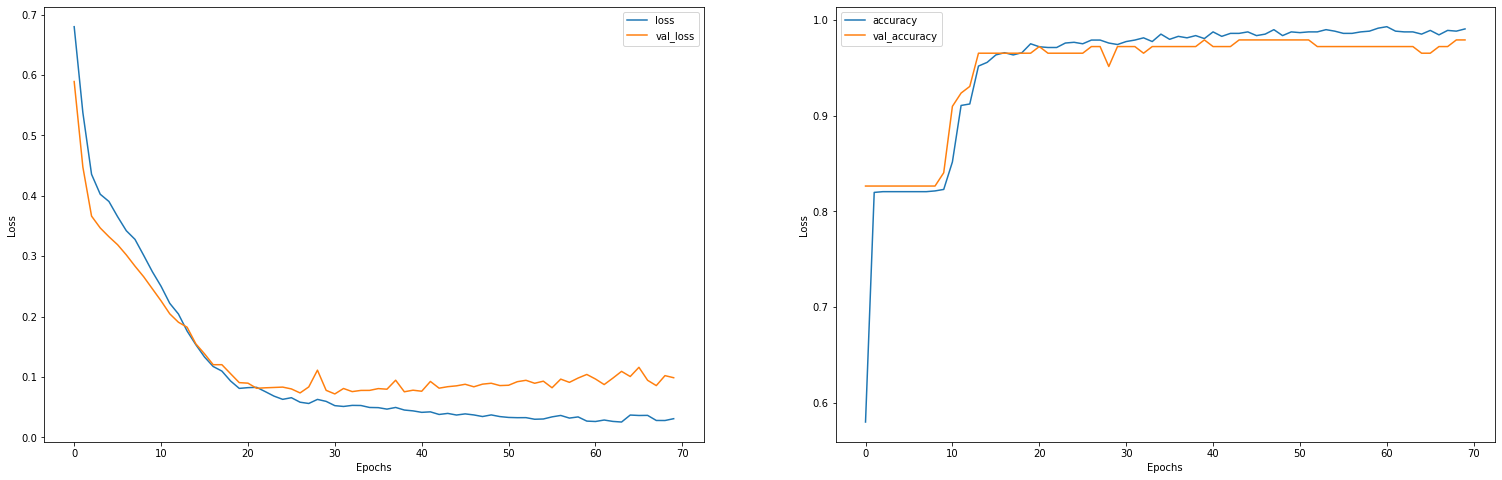

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26,8))

ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.plot(history.history['accuracy'], label="accuracy")
ax2.plot(history.history['val_accuracy'], label="val_accuracy")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
plt.show()

In [99]:
y_pred = model.predict(X_test)

a = y_pred
y_pred_r = np.zeros_like(a)
y_pred_r[np.arange(len(a)), a.argmax(1)] = 1 # set the max of each array to 1, rest to 0

              precision    recall  f1-score   support

      moving       0.99      0.98      0.99       585
        stat       0.92      0.95      0.93       120

   micro avg       0.98      0.98      0.98       705
   macro avg       0.95      0.97      0.96       705
weighted avg       0.98      0.98      0.98       705
 samples avg       0.98      0.98      0.98       705

0.9773049645390071
0.9777039327030645
0.9773049645390071
0.9774520614001763
[[575  10]
 [  6 114]]


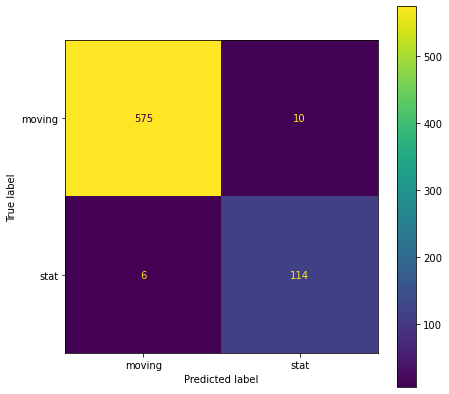

In [100]:
print(classification_report(y_test, y_pred_r, target_names=target_names))

print(recall_score(y_test, y_pred_r, average='weighted'))
print(precision_score(y_test, y_pred_r, average='weighted'))
print(accuracy_score(y_test, y_pred_r))
print(f1_score(y_test, y_pred_r, average='weighted'))

print(confusion_matrix(y_test.argmax(axis=1), y_pred_r.argmax(axis=1)))

fig, ax = plt.subplots(figsize=(7, 7))
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_r.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax)
plt.show()

### TASK 2

Predicting direction of moving tags and location of static tags:

In [101]:
X = ds_EPC.loc[:, Xcols_ds_EPC_lin] 
y = ds_EPC.loc[:, 'actual']

In [102]:
y.value_counts()

moving_OUT_IN    880
moving_IN_OUT    880
stat_IN          209
stat_OUT         167
Name: actual, dtype: int64

In [103]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)

#### SVM

In [104]:
clf=SVC
param_grid = {'C':[10], 'gamma':[0.01], 'kernel':['rbf']}
gs = GridSearchCV(clf(), param_grid, cv=10)

gs.fit(Xtrain, ytrain)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [10], 'gamma': [0.01], 'kernel': ['rbf']})

In [105]:
ypred = gs.predict(Xtest)

In [106]:
target_names = ['moving_OUT_IN', 'moving_IN_OUT', 'stat_IN', 'stat_OUT']

               precision    recall  f1-score   support

moving_OUT_IN       0.97      0.91      0.94       304
moving_IN_OUT       0.92      0.92      0.92       281
      stat_IN       0.79      1.00      0.88        59
     stat_OUT       0.86      0.90      0.88        61

     accuracy                           0.92       705
    macro avg       0.88      0.93      0.90       705
 weighted avg       0.93      0.92      0.92       705

0.9205673758865248
0.9253239550855761
0.9205673758865248
0.921365877246325
[[259   8  10   4]
 [ 19 276   4   5]
 [  0   0  59   0]
 [  4   0   2  55]]


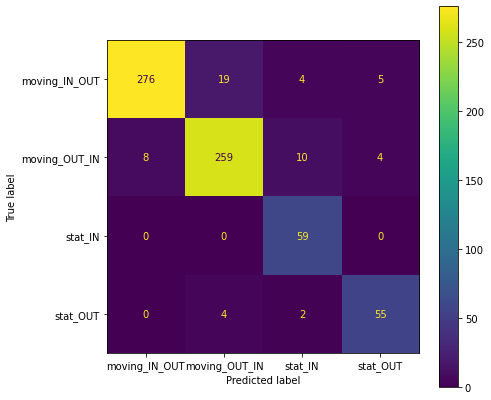

In [107]:
print(classification_report(ytest, ypred, target_names=target_names))

print(recall_score(ytest, ypred, average='weighted'))
print(precision_score(ytest, ypred, average='weighted'))
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred, average='weighted'))
print(confusion_matrix(ytest, ypred, labels=target_names))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(gs, Xtest, ytest, ax=ax)

#### kNN:

               precision    recall  f1-score   support

moving_OUT_IN       0.88      0.88      0.88       304
moving_IN_OUT       0.87      0.85      0.86       281
      stat_IN       0.76      0.85      0.80        59
     stat_OUT       0.85      0.84      0.84        61

     accuracy                           0.86       705
    macro avg       0.84      0.85      0.85       705
 weighted avg       0.86      0.86      0.86       705

0.8638297872340426
0.8649231799998772
0.8638297872340426
0.8641052401420574
[[239  31   9   2]
 [ 23 269   5   7]
 [  5   4  50   0]
 [  7   1   2  51]]


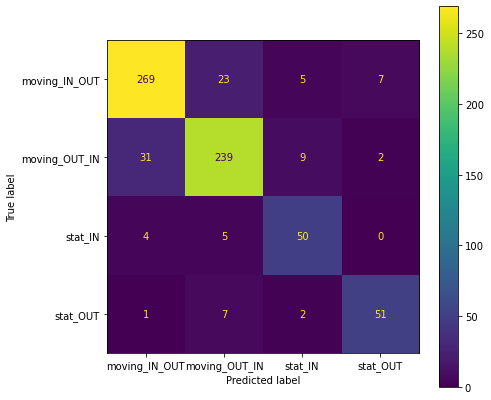

In [108]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(Xtrain, ytrain)

ypred = clf.predict(Xtest)

print(classification_report(ytest, ypred, target_names=target_names))

print(recall_score(ytest, ypred, average='weighted'))
print(precision_score(ytest, ypred, average='weighted'))
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred, average='weighted'))
print(confusion_matrix(ytest, ypred, labels=target_names))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(clf, Xtest, ytest, ax=ax)

               precision    recall  f1-score   support

moving_OUT_IN       0.90      0.88      0.89       304
moving_IN_OUT       0.88      0.88      0.88       281
      stat_IN       0.74      0.88      0.81        59
     stat_OUT       0.88      0.84      0.86        61

     accuracy                           0.88       705
    macro avg       0.85      0.87      0.86       705
 weighted avg       0.88      0.88      0.88       705

0.8765957446808511
0.8788929169946729
0.8765957446808511
0.877166431948681
[[246  24  10   1]
 [ 23 269   6   6]
 [  2   5  52   0]
 [  7   1   2  51]]


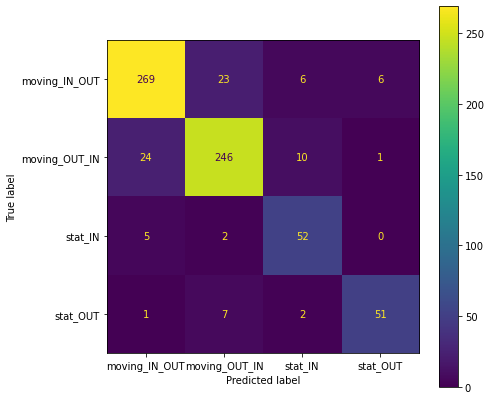

In [109]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(Xtrain, ytrain)

ypred = clf.predict(Xtest)

print(classification_report(ytest, ypred, target_names=target_names))

print(recall_score(ytest, ypred, average='weighted'))
print(precision_score(ytest, ypred, average='weighted'))
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred, average='weighted'))
print(confusion_matrix(ytest, ypred, labels=target_names))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(clf, Xtest, ytest, ax=ax)

#### XGBoost:

               precision    recall  f1-score   support

moving_OUT_IN       0.94      0.91      0.93       304
moving_IN_OUT       0.91      0.94      0.92       281
      stat_IN       0.83      0.90      0.86        59
     stat_OUT       0.94      0.84      0.89        61

     accuracy                           0.92       705
    macro avg       0.90      0.90      0.90       705
 weighted avg       0.92      0.92      0.92       705

0.9163120567375886
0.9176054392569801
0.9163120567375886
0.9163704373512815
[[264  13   4   0]
 [ 21 278   3   2]
 [  2   3  53   1]
 [  4   2   4  51]]


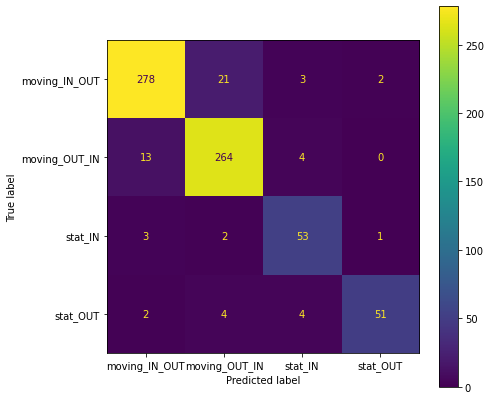

In [110]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

print(classification_report(ytest, ypred, target_names=target_names))

print(recall_score(ytest, ypred, average='weighted'))
print(precision_score(ytest, ypred, average='weighted'))
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred, average='weighted'))
print(confusion_matrix(ytest, ypred, labels=target_names))

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(clf, Xtest, ytest, ax=ax)

#### Deep learning:

In [111]:
X_train = Xtrain
X_test = Xtest

y_train = ytrain.values
y_test = ytest.values

In [112]:
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [113]:
ohe = OneHotEncoder(handle_unknown="ignore")
print(y_train.shape)
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_train = y_train.toarray()
print(y_train.shape)

print(y_test.shape)
y_test = ohe.transform(y_test.reshape(-1,1))
y_test = y_test.toarray()
print(y_test.shape)

(1431,)
(1431, 4)
(705,)
(705, 4)


In [114]:
input_shape = X_train.shape[1]

inputs = keras.Input(shape=(input_shape, ))
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(rate = 0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = keras.Model(inputs, outputs)

opt = Adam(learning_rate=0.0001)

model.compile(optimizer = opt, loss = 'accuracy')

callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.005, patience=30,
                                verbose=2, mode='max', restore_best_weights=True)
                 ]

model.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer='adam') # metrics can be a list of more than 1
history = model.fit(X_train, y_train, validation_split = 0.1, callbacks=callbacks_list,
                    batch_size=128, epochs=200)

Epoch 1/200
11/11 [==============================] - 1s 36ms/step - loss: 1.3145 - accuracy: 0.4406 - val_loss: 1.1845 - val_accuracy: 0.5903
Epoch 2/200
11/11 [==============================] - 0s 4ms/step - loss: 1.1224 - accuracy: 0.5944 - val_loss: 0.9601 - val_accuracy: 0.7153
Epoch 3/200
11/11 [==============================] - 0s 5ms/step - loss: 0.9262 - accuracy: 0.6853 - val_loss: 0.7621 - val_accuracy: 0.7500
Epoch 4/200
11/11 [==============================] - 0s 5ms/step - loss: 0.7532 - accuracy: 0.7389 - val_loss: 0.6433 - val_accuracy: 0.7500
Epoch 5/200
11/11 [==============================] - 0s 4ms/step - loss: 0.6334 - accuracy: 0.7521 - val_loss: 0.5926 - val_accuracy: 0.7431
Epoch 6/200
11/11 [==============================] - 0s 4ms/step - loss: 0.5673 - accuracy: 0.7584 - val_loss: 0.5583 - val_accuracy: 0.7500
Epoch 7/200
11/11 [==============================] - 0s 4ms/step - loss: 0.5207 - accuracy: 0.7661 - val_loss: 0.5238 - val_accuracy: 0.7569
Epoch 8/200


Epoch 59/200
11/11 [==============================] - 0s 5ms/step - loss: 0.1350 - accuracy: 0.9542 - val_loss: 0.2800 - val_accuracy: 0.9028
Epoch 60/200
11/11 [==============================] - 0s 7ms/step - loss: 0.1376 - accuracy: 0.9534 - val_loss: 0.2603 - val_accuracy: 0.9097
Epoch 61/200
11/11 [==============================] - 0s 7ms/step - loss: 0.1362 - accuracy: 0.9542 - val_loss: 0.2585 - val_accuracy: 0.9097
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping


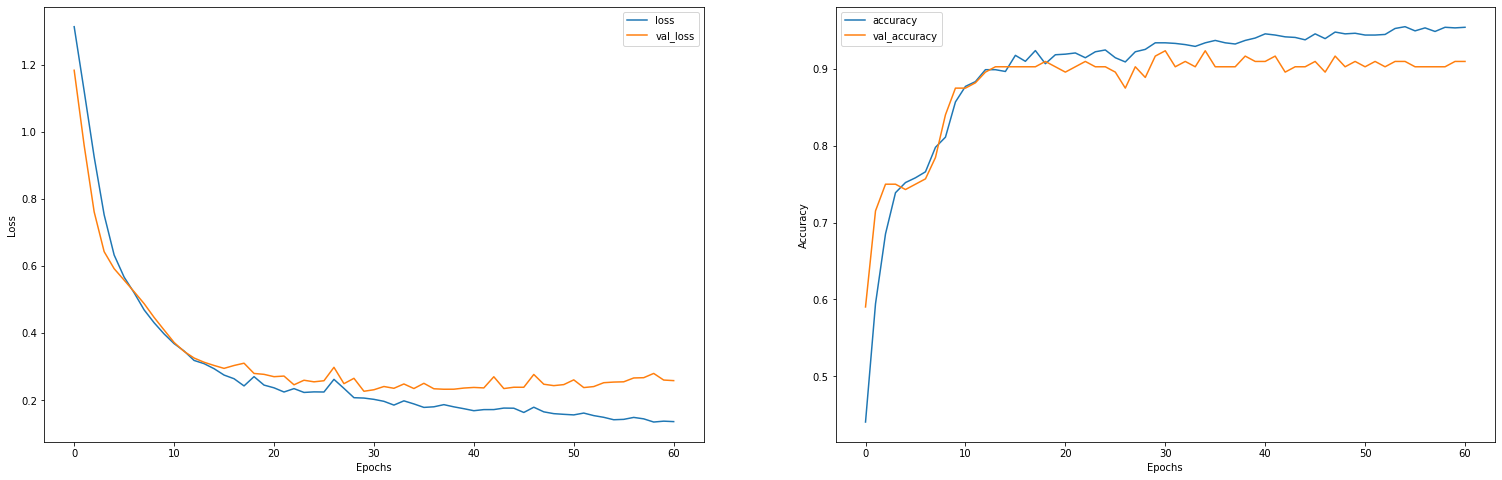

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26,8))

ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(history.history['accuracy'], label="accuracy")
ax2.plot(history.history['val_accuracy'], label="val_accuracy")
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
plt.show()

In [116]:
y_pred = model.predict(X_test)

a = y_pred
y_pred_r = np.zeros_like(a)
y_pred_r[np.arange(len(a)), a.argmax(1)] = 1 # set the max of each array to 1, rest to 0

               precision    recall  f1-score   support

moving_OUT_IN       0.97      0.91      0.94       304
moving_IN_OUT       0.92      0.94      0.93       281
      stat_IN       0.78      0.98      0.87        59
     stat_OUT       0.92      0.89      0.90        61

    micro avg       0.92      0.92      0.92       705
    macro avg       0.90      0.93      0.91       705
 weighted avg       0.93      0.92      0.92       705
  samples avg       0.92      0.92      0.92       705

0.9234042553191489
0.9276248140114868
0.9234042553191489
0.9240903594452602
[[276  20   4   4]
 [  8 263   9   1]
 [  0   1  58   0]
 [  1   3   3  54]]


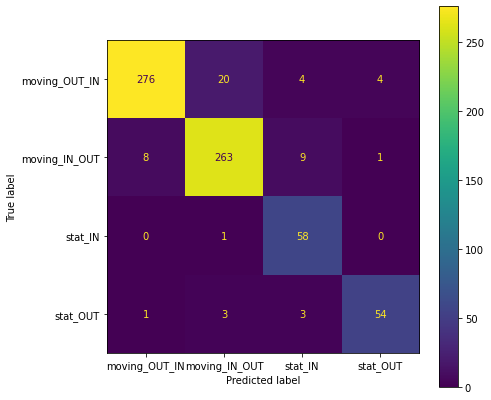

In [117]:
print(classification_report(y_test, y_pred_r, target_names=target_names))

print(recall_score(y_test, y_pred_r, average='weighted'))
print(precision_score(y_test, y_pred_r, average='weighted'))
print(accuracy_score(y_test, y_pred_r))
print(f1_score(y_test, y_pred_r, average='weighted'))

print(confusion_matrix(y_test.argmax(axis=1), y_pred_r.argmax(axis=1)))

fig, ax = plt.subplots(figsize=(7, 7))
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_r.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax)
plt.show()

## ds_gpio

EPCs per window:

In [118]:
EPC_window = ds_rolling_pick.groupby(['run', 'moving_TOI', 'window']) ['EPC'].nunique().reset_index(drop=False)
EPC_window['mid_slot'] = EPC_window['window'].apply(lambda x:x.split('_')[2]).astype(int)
EPC_window = EPC_window.sort_values(['run', 'mid_slot']).reset_index(drop=True) [['run', 'moving_TOI', 'window', 'mid_slot', 'EPC']]
EPC_window[:3]

,run,moving_TOI,window,mid_slot,EPC
0,2022-02-18 17:23:09,A,-13_-12_-11_-10,-11,16
1,2022-02-18 17:23:09,A,-12_-11_-10_-9,-10,25
2,2022-02-18 17:23:09,A,-11_-10_-9_-8,-9,30


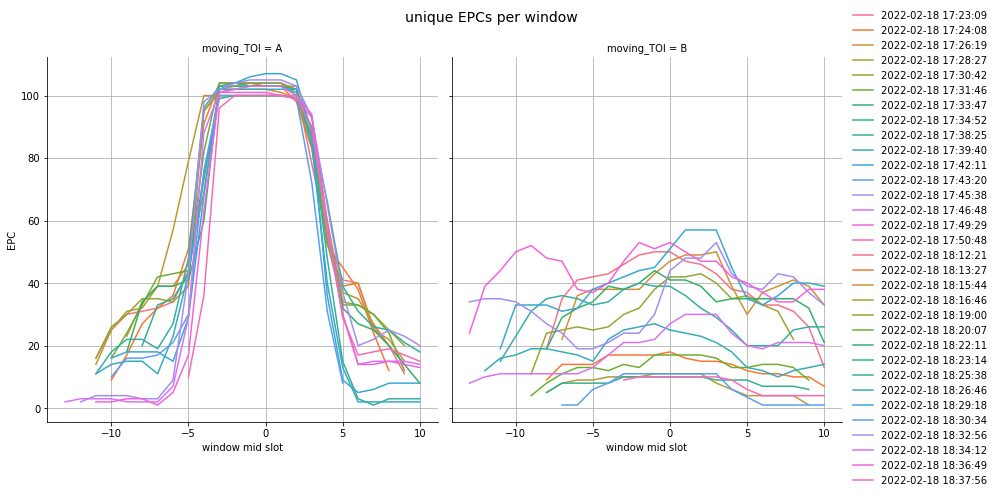

In [119]:
g = sns.FacetGrid(data=EPC_window, col='moving_TOI', height=6)
g.map_dataframe(sns.lineplot, x='mid_slot', y='EPC', hue='run')
g.add_legend()
g.set_xlabels('window mid slot')
plt.suptitle('unique EPCs per window', y=1.05, size=14)
for ax in g.axes.flatten():
    ax.grid()

In [120]:
ds_rolling_pick.head()

,run,EPC,window,keep_out,moving_TOI,moving_motion,RSSImax_ain_0,RSSImax_ain_1,RSSImax_ain_2,RSSImax_ain_3,...,rc_a2_window,rc_a3_window,rc_a4_window,RSSImax_window,RSSIave_window,RSSImin_window,RSSIlinmax_window,RSSIlinave_window,RSSIlinmin_window,rc_window
0,2022-02-18 17:46:48,E28068900000400305C60434,-15_-14_-13_-12,5.0,A,OUT_IN,-85.0,-74.5,-85.0,-74.5,...,0.0,0.0,0.0,-74.5,-82.750000,-85.0,0.035481,0.007603,0.0,6.0
1,2022-02-18 17:46:48,E28068900000500305C60435,-15_-14_-13_-12,5.0,A,OUT_IN,-85.0,-85.0,-80.0,-85.0,...,0.0,0.0,0.0,-80.0,-84.464286,-85.0,0.010000,0.001071,0.0,3.0
2,2022-02-18 17:46:48,E28068900000400305C60434,-14_-13_-12_-11,5.0,A,OUT_IN,-74.5,-85.0,-74.5,-85.0,...,0.0,0.0,0.0,-74.5,-82.750000,-85.0,0.035481,0.007603,0.0,6.0
3,2022-02-18 17:46:48,E28068900000500305C6042D,-14_-13_-12_-11,5.0,A,OUT_IN,-85.0,-85.0,-85.0,-74.5,...,1.0,0.0,0.0,-74.5,-83.875000,-85.0,0.035481,0.003802,0.0,3.0
4,2022-02-18 17:46:48,E28068900000500305C60435,-14_-13_-12_-11,5.0,A,OUT_IN,-85.0,-80.0,-85.0,-79.5,...,0.0,0.0,0.0,-79.5,-83.875000,-85.0,0.011220,0.002274,0.0,6.0


In [121]:
ds_gpio = ds_rolling_pick.copy()
Xcols_ds_gpio = Xcols_ds_rolling
ds_gpio = ds_gpio.drop(columns=['keep_out', 'moving_TOI', 'moving_motion']).reset_index(drop=True)
ds_gpio[:3]

,run,EPC,window,RSSImax_ain_0,RSSImax_ain_1,RSSImax_ain_2,RSSImax_ain_3,RSSImax_aout_0,RSSImax_aout_1,RSSImax_aout_2,...,rc_a2_window,rc_a3_window,rc_a4_window,RSSImax_window,RSSIave_window,RSSImin_window,RSSIlinmax_window,RSSIlinave_window,RSSIlinmin_window,rc_window
0,2022-02-18 17:46:48,E28068900000400305C60434,-15_-14_-13_-12,-85.0,-74.5,-85.0,-74.5,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,-74.5,-82.750000,-85.0,0.035481,0.007603,0.0,6.0
1,2022-02-18 17:46:48,E28068900000500305C60435,-15_-14_-13_-12,-85.0,-85.0,-80.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,-80.0,-84.464286,-85.0,0.010000,0.001071,0.0,3.0
2,2022-02-18 17:46:48,E28068900000400305C60434,-14_-13_-12_-11,-74.5,-85.0,-74.5,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,-74.5,-82.750000,-85.0,0.035481,0.007603,0.0,6.0


In [122]:
ds_gpio.shape, ds_gpio [ds_gpio['rc_window']!=0].shape

((25092, 248), (25092, 248))

### Unstack by EPC

In [123]:
ds_gpio = ds_gpio.set_index(['run', 'EPC', 'window']).unstack('EPC')
Xcols_ds_gpio = ds_gpio.columns
Xcols_ds_gpio = [f'{x[0]}__{x[1]}' for x in Xcols_ds_gpio]
ds_gpio.columns = Xcols_ds_gpio

ds_gpio = ds_gpio.reset_index(drop=False)
ds_gpio[:3]

,run,window,RSSImax_ain_0__AD3830770CCDD0AD383001C3,RSSImax_ain_0__AD3830770CCDD0AD383001C8,RSSImax_ain_0__AD3830770CCDD0AD383001C9,RSSImax_ain_0__AD3830770CCDD0AD383001CB,RSSImax_ain_0__AD3830770CCDD0AD383001CE,RSSImax_ain_0__AD3830770CCDD0AD383001DE,RSSImax_ain_0__AD3830770CCDD0AD383001E0,RSSImax_ain_0__AD3830770CCDD0AD383001E3,...,rc_window__E28068900000400305C6014F,rc_window__E28068900000400305C6042F,rc_window__E28068900000400305C60431,rc_window__E28068900000400305C60432,rc_window__E28068900000400305C60434,rc_window__E28068900000500305C6042D,rc_window__E28068900000500305C6042E,rc_window__E28068900000500305C60430,rc_window__E28068900000500305C60433,rc_window__E28068900000500305C60435
0,2022-02-18 17:23:09,-10_-9_-8_-7,-72.5,-85.0,NaN,-85.0,-71.0,NaN,NaN,-85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,15.0
1,2022-02-18 17:23:09,-11_-10_-9_-8,-85.0,-85.0,NaN,-85.0,-85.0,NaN,NaN,-85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0
2,2022-02-18 17:23:09,-12_-11_-10_-9,-85.0,-85.0,NaN,-85.0,-85.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,9.0


In [124]:
ds_EPC['EPC'].nunique(), len(Xcols_ds_rolling), len(Xcols_ds_gpio)

(110, 245, 26950)

In [125]:
Xcols_ds_gpio[:3], Xcols_ds_gpio[-3:]

(['RSSImax_ain_0__AD3830770CCDD0AD383001C3',
  'RSSImax_ain_0__AD3830770CCDD0AD383001C8',
  'RSSImax_ain_0__AD3830770CCDD0AD383001C9'],
 ['rc_window__E28068900000500305C60430',
  'rc_window__E28068900000500305C60433',
  'rc_window__E28068900000500305C60435'])

In [126]:
for col in Xcols_ds_gpio: # fill NA values
    if 'RSSI' in col:
        if 'lin' not in col:
            fill_value=-85
        else:
            fill_value=0
    else:
        fill_value=0
    
    ds_gpio[col] = ds_gpio[col].fillna(fill_value)
ds_gpio.head()

,run,window,RSSImax_ain_0__AD3830770CCDD0AD383001C3,RSSImax_ain_0__AD3830770CCDD0AD383001C8,RSSImax_ain_0__AD3830770CCDD0AD383001C9,RSSImax_ain_0__AD3830770CCDD0AD383001CB,RSSImax_ain_0__AD3830770CCDD0AD383001CE,RSSImax_ain_0__AD3830770CCDD0AD383001DE,RSSImax_ain_0__AD3830770CCDD0AD383001E0,RSSImax_ain_0__AD3830770CCDD0AD383001E3,...,rc_window__E28068900000400305C6014F,rc_window__E28068900000400305C6042F,rc_window__E28068900000400305C60431,rc_window__E28068900000400305C60432,rc_window__E28068900000400305C60434,rc_window__E28068900000500305C6042D,rc_window__E28068900000500305C6042E,rc_window__E28068900000500305C60430,rc_window__E28068900000500305C60433,rc_window__E28068900000500305C60435
0,2022-02-18 17:23:09,-10_-9_-8_-7,-72.5,-85.0,-85.0,-85.0,-71.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,15.0
1,2022-02-18 17:23:09,-11_-10_-9_-8,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0
2,2022-02-18 17:23:09,-12_-11_-10_-9,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.0
3,2022-02-18 17:23:09,-13_-12_-11_-10,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,2022-02-18 17:23:09,-1_0_1_2,-66.0,-85.0,-85.0,-85.0,-85.0,-85.0,-66.5,-85.0,...,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0


In [127]:
ds_gpio.isna().mean().mean()

0.0

In [128]:
ds_gpio ['1st_slot'] = ds_gpio['window'].apply(lambda x:x.split('_')[0]).astype(int)
ds_gpio = ds_gpio [['run', 'window', '1st_slot'] +Xcols_ds_gpio]
ds_gpio = ds_gpio.sort_values(['run', '1st_slot']).reset_index(drop=True)
ds_gpio.head()

,run,window,1st_slot,RSSImax_ain_0__AD3830770CCDD0AD383001C3,RSSImax_ain_0__AD3830770CCDD0AD383001C8,RSSImax_ain_0__AD3830770CCDD0AD383001C9,RSSImax_ain_0__AD3830770CCDD0AD383001CB,RSSImax_ain_0__AD3830770CCDD0AD383001CE,RSSImax_ain_0__AD3830770CCDD0AD383001DE,RSSImax_ain_0__AD3830770CCDD0AD383001E0,...,rc_window__E28068900000400305C6014F,rc_window__E28068900000400305C6042F,rc_window__E28068900000400305C60431,rc_window__E28068900000400305C60432,rc_window__E28068900000400305C60434,rc_window__E28068900000500305C6042D,rc_window__E28068900000500305C6042E,rc_window__E28068900000500305C60430,rc_window__E28068900000500305C60433,rc_window__E28068900000500305C60435
0,2022-02-18 17:23:09,-13_-12_-11_-10,-13,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1,2022-02-18 17:23:09,-12_-11_-10_-9,-12,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.0
2,2022-02-18 17:23:09,-11_-10_-9_-8,-11,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0
3,2022-02-18 17:23:09,-10_-9_-8_-7,-10,-72.5,-85.0,-85.0,-85.0,-71.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,15.0
4,2022-02-18 17:23:09,-9_-8_-7_-6,-9,-85.0,-69.0,-85.0,-76.5,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,15.0


In [129]:
ds_gpio['1st_slot'].describe()

count    644.000000
mean      -2.223602
std        6.064429
min      -15.000000
25%       -7.000000
50%       -2.000000
75%        3.000000
max        8.000000
Name: 1st_slot, dtype: float64

In [130]:
Xcols_ds_gpio_lin = [x for x in Xcols_ds_gpio if ('RSSI' not in x) | ('RSSIlin' in x)]
len(Xcols_ds_gpio_lin), len(Xcols_ds_gpio), (ds_gpio[Xcols_ds_gpio_lin].sum(axis=1) == 0).sum()

(15400, 26950, 0)

### creating the target feature "crossing"

In [131]:
crossing_window

'-2_-1_0_1'

In [132]:
crit = (ds_gpio['window']==crossing_window)
ds_gpio['actual'] = np.where(crit, 'crossing', 'no crossing')
ds_gpio = ds_gpio [['run', 'window', '1st_slot', 'actual'] +Xcols_ds_gpio].reset_index(drop=True)
ds_gpio[:16]

,run,window,1st_slot,actual,RSSImax_ain_0__AD3830770CCDD0AD383001C3,RSSImax_ain_0__AD3830770CCDD0AD383001C8,RSSImax_ain_0__AD3830770CCDD0AD383001C9,RSSImax_ain_0__AD3830770CCDD0AD383001CB,RSSImax_ain_0__AD3830770CCDD0AD383001CE,RSSImax_ain_0__AD3830770CCDD0AD383001DE,...,rc_window__E28068900000400305C6014F,rc_window__E28068900000400305C6042F,rc_window__E28068900000400305C60431,rc_window__E28068900000400305C60432,rc_window__E28068900000400305C60434,rc_window__E28068900000500305C6042D,rc_window__E28068900000500305C6042E,rc_window__E28068900000500305C60430,rc_window__E28068900000500305C60433,rc_window__E28068900000500305C60435
0,2022-02-18 17:23:09,-13_-12_-11_-10,-13,no crossing,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1,2022-02-18 17:23:09,-12_-11_-10_-9,-12,no crossing,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.0
2,2022-02-18 17:23:09,-11_-10_-9_-8,-11,no crossing,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0
3,2022-02-18 17:23:09,-10_-9_-8_-7,-10,no crossing,-72.5,-85.0,-85.0,-85.0,-71.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,15.0
4,2022-02-18 17:23:09,-9_-8_-7_-6,-9,no crossing,-85.0,-69.0,-85.0,-76.5,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,15.0
5,2022-02-18 17:23:09,-8_-7_-6_-5,-8,no crossing,-73.5,-85.0,-85.0,-77.5,-74.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,15.0
6,2022-02-18 17:23:09,-7_-6_-5_-4,-7,no crossing,-85.0,-71.5,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,18.0
7,2022-02-18 17:23:09,-6_-5_-4_-3,-6,no crossing,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,15.0
8,2022-02-18 17:23:09,-5_-4_-3_-2,-5,no crossing,-85.0,-73.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0
9,2022-02-18 17:23:09,-4_-3_-2_-1,-4,no crossing,-85.0,-68.5,-85.0,-85.0,-70.5,-66.5,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,6.0,9.0


In [133]:
ds_gpio.shape

(644, 26954)

In [134]:
ds_gpio.groupby('actual').size()

actual
crossing        32
no crossing    612
dtype: int64

In [135]:
Xcols_ds_gpio_lin[:3], Xcols_ds_gpio_lin[-3:]

(['RSSIlinmax_ain_0__AD3830770CCDD0AD383001C3',
  'RSSIlinmax_ain_0__AD3830770CCDD0AD383001C8',
  'RSSIlinmax_ain_0__AD3830770CCDD0AD383001C9'],
 ['rc_window__E28068900000500305C60430',
  'rc_window__E28068900000500305C60433',
  'rc_window__E28068900000500305C60435'])

In [136]:
Xcols_gpio_empty = ds_gpio[Xcols_ds_gpio_lin].sum()==0
Xcols_gpio_empty = Xcols_gpio_empty [Xcols_gpio_empty].index
Xcols_gpio_empty[:3], Xcols_gpio_empty[-3:], len(Xcols_gpio_empty)

(Index(['RSSIlinmin_ain_window__AD3830770CCDD0AD383001C3',
        'RSSIlinmin_ain_window__AD3830770CCDD0AD383001C9',
        'RSSIlinmin_ain_window__AD3830770CCDD0AD383001CE'],
       dtype='object'),
 Index(['RSSIlinmin_window__E28068900000500305C60430',
        'RSSIlinmin_window__E28068900000500305C60433',
        'RSSIlinmin_window__E28068900000500305C60435'],
       dtype='object'),
 517)

In [137]:
len(Xcols_ds_gpio)

26950

### Eliminate empty columns

In [138]:
Xcols_ds_gpio = [x for x in Xcols_ds_gpio if x not in Xcols_gpio_empty]
len(Xcols_ds_gpio)

26433

In [139]:
len(Xcols_ds_gpio_lin)

15400

In [140]:
Xcols_ds_gpio_lin = [x for x in Xcols_ds_gpio_lin if x not in Xcols_gpio_empty]
len(Xcols_ds_gpio_lin)

14883

In [141]:
ds_gpio[:3]

,run,window,1st_slot,actual,RSSImax_ain_0__AD3830770CCDD0AD383001C3,RSSImax_ain_0__AD3830770CCDD0AD383001C8,RSSImax_ain_0__AD3830770CCDD0AD383001C9,RSSImax_ain_0__AD3830770CCDD0AD383001CB,RSSImax_ain_0__AD3830770CCDD0AD383001CE,RSSImax_ain_0__AD3830770CCDD0AD383001DE,...,rc_window__E28068900000400305C6014F,rc_window__E28068900000400305C6042F,rc_window__E28068900000400305C60431,rc_window__E28068900000400305C60432,rc_window__E28068900000400305C60434,rc_window__E28068900000500305C6042D,rc_window__E28068900000500305C6042E,rc_window__E28068900000500305C60430,rc_window__E28068900000500305C60433,rc_window__E28068900000500305C60435
0,2022-02-18 17:23:09,-13_-12_-11_-10,-13,no crossing,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1,2022-02-18 17:23:09,-12_-11_-10_-9,-12,no crossing,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.0
2,2022-02-18 17:23:09,-11_-10_-9_-8,-11,no crossing,-85.0,-85.0,-85.0,-85.0,-85.0,-85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0


In [142]:
len(Xcols_ds_gpio_lin), len(ds_gpio), len(Xcols_ds_gpio_lin) * len(ds_gpio) # how many cells in gpio

(14883, 644, 9584652)

In [143]:
zeros=0
for row in ds_gpio.index:
    for col in Xcols_ds_gpio_lin:
        value = ds_gpio.loc[row, col]
        if value == 0:
            zeros = zeros +1
            
zeros # how many zeros in ds - very sparse...

8688426

In [144]:
ds_gpio.groupby('actual').size() # highly unbalanced target feature

actual
crossing        32
no crossing    612
dtype: int64

## MACHINE LEARNING

### TASK 3

Predicting if the tags crossed the dock door:

In [145]:
ds_gpio_shuffle = ds_gpio.sort_values(['run', '1st_slot']).sample(frac=1)

In [146]:
X = ds_gpio_shuffle.loc[:, Xcols_ds_gpio_lin]
y = ds_gpio_shuffle.loc[:, 'actual']

In [147]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4, stratify=y) #, stratify=y, shuffle=True

In [148]:
from imblearn.over_sampling import SMOTE # to combat imbalance, we oversample "crossing" in the training set - leave
                                         # testing set as-is.
    
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(Xtrain, ytrain)

In [149]:
y_res.value_counts()

no crossing    367
crossing       367
Name: actual, dtype: int64

#### SVM:

In [150]:
clf = SVC
param_grid = {'C':[1], 'gamma':[0.001], 'kernel':['rbf']}

gs = GridSearchCV(clf(), param_grid, cv=5)

In [151]:
gs.fit(X_res, y_res)
ypred = gs.predict(Xtest)

In [152]:
target_names = ['crossing', 'no crossing']

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\

              precision    recall  f1-score   support

    crossing       0.00      0.00      0.00        13
 no crossing       0.95      1.00      0.97       245

    accuracy                           0.95       258
   macro avg       0.47      0.50      0.49       258
weighted avg       0.90      0.95      0.93       258

0.9496124031007752
0.9017637161228291
0.9496124031007752
0.9250697366190455
[[  0  13]
 [  0 245]]


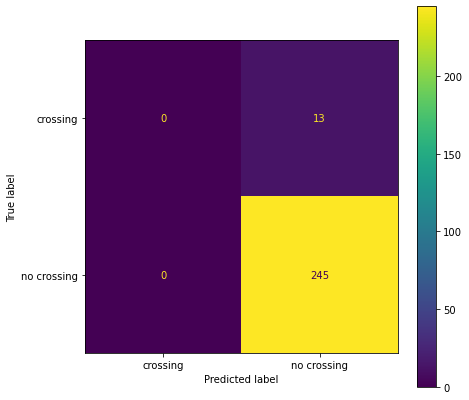

In [153]:
print(classification_report(ytest, ypred, target_names=target_names))

print(recall_score(ytest, ypred, average='weighted'))
print(precision_score(ytest, ypred, average='weighted'))
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred, average='weighted'))
print(confusion_matrix(ytest, ypred, labels=target_names))

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(gs, Xtest, ytest, ax=ax)

#### kNN:

              precision    recall  f1-score   support

    crossing       0.24      0.46      0.32        13
 no crossing       0.97      0.92      0.95       245

    accuracy                           0.90       258
   macro avg       0.60      0.69      0.63       258
weighted avg       0.93      0.90      0.91       258

0.8992248062015504
0.9331762983664371
0.8992248062015504
0.9138717183149564
[[  6   7]
 [ 19 226]]


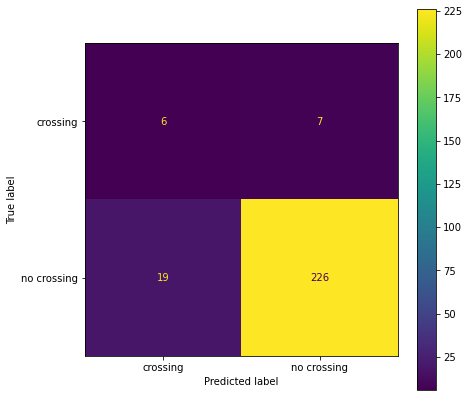

In [154]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_res, y_res)

ypred = clf.predict(Xtest)

print(classification_report(ytest, ypred, target_names=target_names))

print(recall_score(ytest, ypred, average='weighted'))
print(precision_score(ytest, ypred, average='weighted'))
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred, average='weighted'))
print(confusion_matrix(ytest, ypred, labels=target_names))

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(clf, Xtest, ytest, ax=ax)

              precision    recall  f1-score   support

    crossing       0.23      0.54      0.33        13
 no crossing       0.97      0.91      0.94       245

    accuracy                           0.89       258
   macro avg       0.60      0.72      0.63       258
weighted avg       0.94      0.89      0.91       258

0.8875968992248062
0.9363797089623282
0.8875968992248062
0.9077961879476212
[[  7   6]
 [ 23 222]]


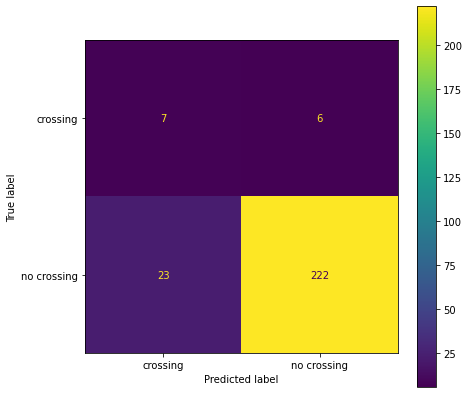

In [155]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_res, y_res)

ypred = clf.predict(Xtest)

print(classification_report(ytest, ypred, target_names=target_names))

print(recall_score(ytest, ypred, average='weighted'))
print(precision_score(ytest, ypred, average='weighted'))
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred, average='weighted'))
print(confusion_matrix(ytest, ypred, labels=target_names))

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(clf, Xtest, ytest, ax=ax)

#### XGBoost:

              precision    recall  f1-score   support

    crossing       0.75      0.23      0.35        13
 no crossing       0.96      1.00      0.98       245

    accuracy                           0.96       258
   macro avg       0.86      0.61      0.67       258
weighted avg       0.95      0.96      0.95       258

0.9573643410852714
0.950016785692486
0.9573643410852714
0.9464629212826016
[[  3  10]
 [  1 244]]


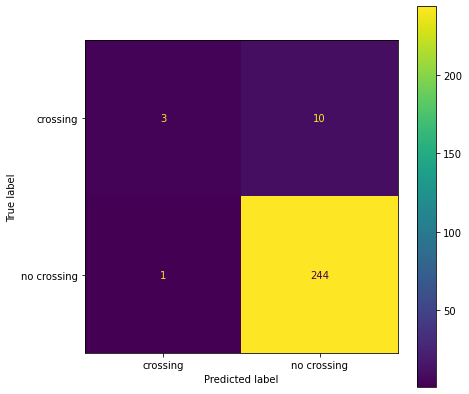

In [156]:
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.5, max_depth=1, random_state=0)

clf.fit(X_res, y_res)
ypred = clf.predict(Xtest)

print(classification_report(ytest, ypred, target_names=target_names))

print(recall_score(ytest, ypred, average='weighted'))
print(precision_score(ytest, ypred, average='weighted'))
print(accuracy_score(ytest, ypred))
print(f1_score(ytest, ypred, average='weighted'))
print(confusion_matrix(ytest, ypred, labels=target_names))

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(clf, Xtest, ytest, ax=ax)

#### Deep learning:

In [157]:
X_train = X_res
X_test = Xtest

y_train = y_res.values
y_test = ytest.values

In [158]:
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [159]:
ohe = OneHotEncoder(handle_unknown="ignore")
print(y_train.shape)
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_train = y_train.toarray()
print(y_train.shape)

print(y_test.shape)
y_test = ohe.transform(y_test.reshape(-1,1))
y_test = y_test.toarray()
print(y_test.shape)

(734,)
(734, 2)
(258,)
(258, 2)


In [160]:
input_shape = X_train.shape[1]

inputs = keras.Input(shape=(input_shape, ))
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
x = Dropout(rate = 0.4)(x)
outputs = Dense(2, activation='softmax')(x)

model = keras.Model(inputs, outputs)

opt = Adam(learning_rate=0.0001)

model.compile(optimizer = opt, loss = 'accuracy')

callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.005, patience=30,
                                verbose=2, mode='max', restore_best_weights=True)
                 ]

model.compile(loss='categorical_crossentropy', metrics=["accuracy"], optimizer='adam') # metrics can be a list of more than 1
history = model.fit(X_train, y_train, validation_split = 0.1, callbacks=callbacks_list,
                    batch_size=128, epochs=200)

Epoch 1/200
6/6 [==============================] - 1s 55ms/step - loss: 0.5581 - accuracy: 0.6621 - val_loss: 0.0783 - val_accuracy: 1.0000
Epoch 2/200
6/6 [==============================] - 0s 20ms/step - loss: 0.2683 - accuracy: 0.9545 - val_loss: 0.0245 - val_accuracy: 1.0000
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 0.1182 - accuracy: 0.9924 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 4/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0678 - accuracy: 0.9970 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0411 - accuracy: 1.0000 - val_loss: 5.4711e-04 - val_accuracy: 1.0000
Epoch 6/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0291 - accuracy: 1.0000 - val_loss: 6.4326e-04 - val_accuracy: 1.0000
Epoch 7/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0225 - accuracy: 0.9985 - val_loss: 1.3745e-04 - val_accuracy: 1.0000
Epoch 8/

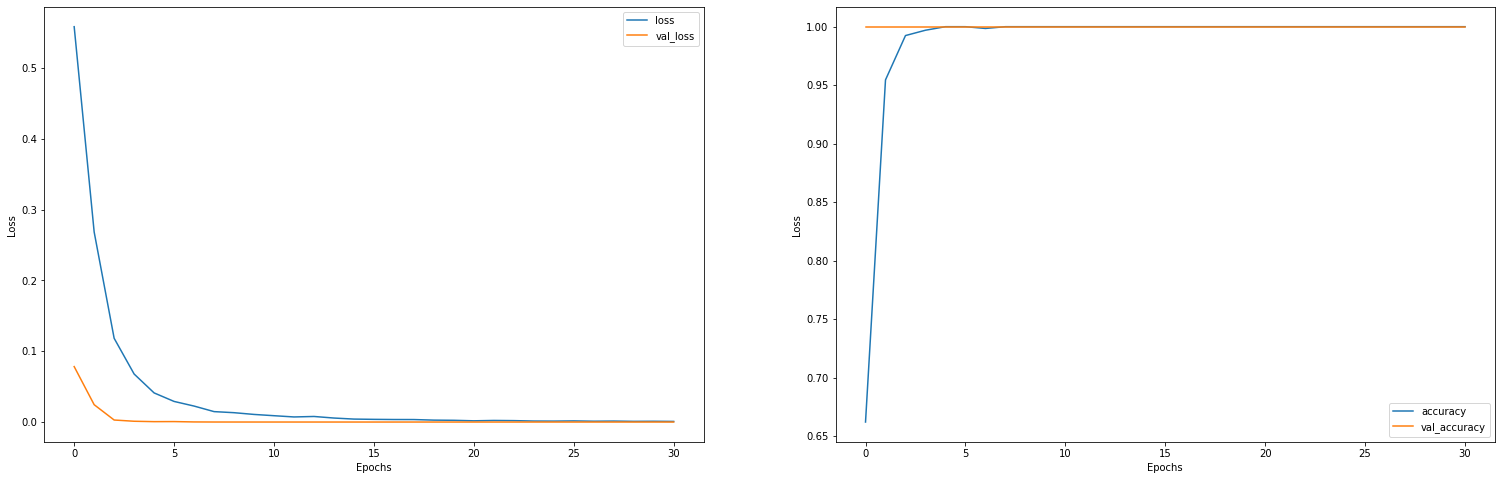

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26,8))

ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Loss")
ax2.plot(history.history['accuracy'], label="accuracy")
ax2.plot(history.history['val_accuracy'], label="val_accuracy")
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Loss")
plt.show()

In [162]:
y_pred = model.predict(X_test)

a = y_pred
y_pred_r = np.zeros_like(a)
y_pred_r[np.arange(len(a)), a.argmax(1)] = 1 # set the max of each array to 1, rest to 0

              precision    recall  f1-score   support

    crossing       0.10      0.38      0.16        13
 no crossing       0.96      0.81      0.88       245

   micro avg       0.79      0.79      0.79       258
   macro avg       0.53      0.60      0.52       258
weighted avg       0.92      0.79      0.84       258
 samples avg       0.79      0.79      0.79       258

0.7906976744186046
0.917852367325989
0.7906976744186046
0.8440361957192838
[[  5   8]
 [ 46 199]]


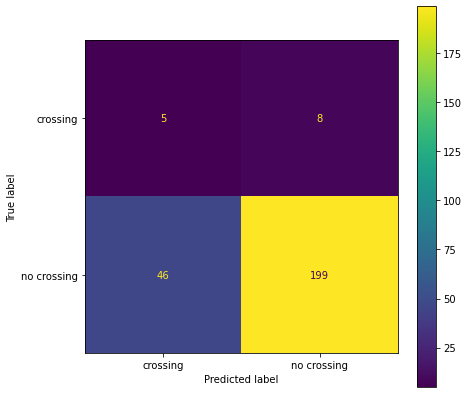

In [163]:
print(classification_report(y_test, y_pred_r, target_names=target_names))

print(recall_score(y_test, y_pred_r, average='weighted'))
print(precision_score(y_test, y_pred_r, average='weighted'))
print(accuracy_score(y_test, y_pred_r))
print(f1_score(y_test, y_pred_r, average='weighted'))

print(confusion_matrix(y_test.argmax(axis=1), y_pred_r.argmax(axis=1)))

fig, ax = plt.subplots(figsize=(7, 7))
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_r.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax)
plt.show()